# Putting the 3 chapters together...

In [1]:
### Importing packages and functions
import sys
import os

In [2]:
os.environ['AUTO_DIR'] = '/home/contreras//Documents/Auto4Servers/compute2/auto-07p'

In [3]:
#### This should be set as the path of auto in your own computer, if you didn't add the path to your bashrc file
# os.environ['AUTO_DIR'] = '/path2auto/auto-07p'
import numpy as np
import pylab, json, sympy, scipy
import matplotlib
from matplotlib import pyplot as plt
from scipy.integrate import odeint
from matplotlib import rc
from copy import copy
### Importing created functions to load model
from m_generic_neuron_from_json import generic_neuron_from_json
from m_generic_neuron_from_json import load_mod
### Something for sympy to work with python 3
from sympy import S
from operator import itemgetter
### to create temp files in every run
import contextlib
import tempfile
import shutil
### Import auto stuff
import autoutils
import auto

In [4]:
## Hack for auto to work
%load_ext autoreload
%autoreload 2

In [5]:
# This is to run auto related stuff in a temporary folder (files are created in every run, and are not needed later)
@contextlib.contextmanager
def TemporaryDirectory(suffix="", prefix="tmp", dir=None):
    name = tempfile.mkdtemp(suffix, prefix, dir)
    try:
        yield name
    finally:
        shutil.rmtree(name)

In [6]:
# This is to save the data used to draw the bifurcation diagram
import pickle
def save_obj(obj, name ):
    with open( name + '.pkl', 'wb') as f:
        pickle.dump(obj, f, pickle.HIGHEST_PROTOCOL)

dir_sims='./Data/'

In [7]:
def saving_pdf_figure(fig,fig_name,md_dir):
    from matplotlib.backends.backend_pdf import PdfPages
    ax=plt.figure()
    ax=fig
    ax2=fig
    pdffig = PdfPages(fig_name+".pdf")
    ax.savefig(fig_name+'.png',dpi=200)
    fig.savefig(pdffig, format="pdf")
    metadata = pdffig.infodict()
    metadata['Title'] = md_dir['Title']
    metadata['Author'] = md_dir['Author']
    metadata['Subject'] = md_dir['Subject']
    metadata['Keywords'] = md_dir['Keywords']
    pdffig.close()

In [8]:
def zoomingBox(ax1, roi, ax2, color='red', linewidth=2, roiKwargs={}, arrowKwargs={}):
    from matplotlib.patches import Rectangle
    '''
    **Notes (for reasons unknown to me)**
    1. Sometimes the zorder of the axes need to be adjusted manually...
    2. The figure fraction is accurate only with qt backend but not inline...
    '''
    roiKwargs = dict([('fill',False), ('linestyle','dashed'), ('color',color), ('linewidth',linewidth)] + list(roiKwargs.items()))
    ax1.add_patch(Rectangle([roi[0],roi[2]], roi[1]-roi[0], roi[3]-roi[2], **roiKwargs))
    arrowKwargs = dict([('arrowstyle','-'), ('color',color), ('linewidth',linewidth)] + list(arrowKwargs.items()))
    srcCorners = [[roi[0],roi[2]], [roi[0],roi[3]], [roi[1],roi[2]], [roi[1],roi[3]]]
    dstCorners = ax2.get_position().corners()
    srcBB = ax1.get_position()
    dstBB = ax2.get_position()
    if (dstBB.min[0]>srcBB.max[0] and dstBB.max[1]<srcBB.min[1]) or (dstBB.max[0]<srcBB.min[0] and dstBB.min[1]>srcBB.max[1]):
        src = [0, 3]; dst = [0, 3]
    elif (dstBB.max[0]<srcBB.min[0] and dstBB.max[1]<srcBB.min[1]) or (dstBB.min[0]>srcBB.max[0] and dstBB.min[1]>srcBB.max[1]):
        src = [1, 2]; dst = [1, 2]
    elif dstBB.max[1] < srcBB.min[1]:
        src = [0, 2]; dst = [1, 3]
    elif dstBB.min[1] > srcBB.max[1]:
        src = [1, 3]; dst = [0, 2]
    elif dstBB.max[0] < srcBB.min[0]:
        src = [0, 1]; dst = [2, 3]
    elif dstBB.min[0] > srcBB.max[0]:
        src = [2, 3]; dst = [0, 1]
    for k in range(2):
        ax1.annotate('', xy=dstCorners[dst[k]], xytext=srcCorners[src[k]], xycoords='figure fraction', textcoords='data', arrowprops=arrowKwargs)

In [9]:
def zoomingBox_4PhasePlane(ax1, roi, ax2, color='red', linewidth=2, roiKwargs={}, arrowKwargs={}):
    from matplotlib.patches import Rectangle
    '''
    **Notes (for reasons unknown to me)**
    1. Sometimes the zorder of the axes need to be adjusted manually...
    2. The figure fraction is accurate only with qt backend but not inline...
    '''
    roiKwargs = dict([('fill',False), ('linestyle','dashed'), ('color',color), ('linewidth',linewidth)] + list(roiKwargs.items()))
    ax1.add_patch(Rectangle([roi[0],roi[2]], roi[1]-roi[0], roi[3]-roi[2], **roiKwargs))
    arrowKwargs = dict([('arrowstyle','-'), ('color',color), ('linewidth',linewidth)] + list(arrowKwargs.items()))
    srcCorners = [[roi[0],roi[2]], [roi[0],roi[3]], [roi[1],roi[2]], [roi[1],roi[3]]]
    dstCorners = ax2.get_position().corners()
    srcBB = ax1.get_position()
    dstBB = ax2.get_position()
    src = [3, 1]; dst = [2, 0]
#     if (dstBB.min[0]>srcBB.max[0] and dstBB.max[1]<srcBB.min[1]) or (dstBB.max[0]<srcBB.min[0] and dstBB.min[1]>srcBB.max[1]):
#         src = [0, 3]; dst = [0, 3]
#     elif (dstBB.max[0]<srcBB.min[0] and dstBB.max[1]<srcBB.min[1]) or (dstBB.min[0]>srcBB.max[0] and dstBB.min[1]>srcBB.max[1]):
#         src = [1, 2]; dst = [1, 2]
#     elif dstBB.max[1] < srcBB.min[1]:
#         src = [0, 2]; dst = [1, 3]
#     elif dstBB.min[1] > srcBB.max[1]:
#         src = [1, 3]; dst = [0, 2]
#     elif dstBB.max[0] < srcBB.min[0]:
#         src = [0, 1]; dst = [2, 3]
#     elif dstBB.min[0] > srcBB.max[0]:
#         src = [2, 3]; dst = [0, 1]
    for k in range(2):
        ax1.annotate('', xy=dstCorners[dst[k]], xytext=srcCorners[src[k]], xycoords='figure fraction', textcoords='data', arrowprops=arrowKwargs)

In [10]:
# This function extracts sympy expressions from the class neuron (neuron_snap) that are then used by auto, and runs an ode to find the steady state
def get_Jacobian(neuron_snap,bifpar,autobifpart):
    # Creating a copy of neuron model to give to ode
    neuron_fromgen_4sim=copy(neuron_snap)
    # Creating a copy of neuron model to give to auto
    neuron_fromgen_4auto=copy(neuron_snap)
    neuron_fromgen_4auto.changing_pars(bifpar,pars4auto=True,strIapp=strIapp)
    #### Extracting expressions
    s_svars=neuron_fromgen_4auto.s_state_vars
    svarsexp=neuron_fromgen_4auto.svarsexp
    varrhs =zip(s_svars,svarsexp)
    varrhs=sorted(varrhs, key=itemgetter(0), reverse=True)
    var,rhs = zip(*varrhs);
    advar = sympy.S(["ad{}".format(k) for k in var])
    #Creating jacobian
    J = [[S(i).diff(j) for j in var] for i in rhs]
    return(J)

In [11]:
from sympy.utilities.lambdify import lambdify
from numpy import linalg as LA
from copy import copy
# This function extracts sympy expressions from the class neuron (neuron_snap) that are then used by auto
def get_expressions(neuron_snap,bifpar,autobifpart={}):
    from copy import copy
    # Creating a copy of neuron model to give to ode
    neuron_fromgen_4sim=copy(neuron_snap)
    # Creating a copy of neuron model to give to auto
    neuron_fromgen_4auto=copy(neuron_snap)
    neuron_fromgen_4auto.changing_pars(bifpar,pars4auto=True,strIapp=strIapp)
    #### Extracting expressions
    s_svars=neuron_fromgen_4auto.s_state_vars
    svarsexp=neuron_fromgen_4auto.svarsexp
    varrhs =zip(s_svars,svarsexp)
    varrhs=sorted(varrhs, key=itemgetter(0), reverse=True)
    var,rhs = zip(*varrhs);
    advar = sympy.S(["ad{}".format(k) for k in var])
    #Creating jacobian
    J = [[S(i).diff(j) for j in var] for i in rhs]
    adlinsys = [str(k) for k in
                (sympy.S("lam")*sympy.eye(len(advar))-sympy.Matrix(J).T)*sympy.Matrix(advar)]
    prcnorm=str((sympy.Matrix(sympy.S(advar)).T*sympy.Matrix(sympy.S(rhs)))[0,0] - sympy.S("dotZF/period"))
    spikecriterion = [str(S(k).subs([(i,"{}_left".format(i)) for i in var]))
                      for j,k in zip(var,rhs) if j=="v"]
    return var,rhs,spikecriterion,J


# This function extracts sympy expressions from the class neuron (neuron_snap) that are then used by auto, and runs an ode to find the steady state
def get_expressions_and_ss(neuron_snap,bifpar,autobifpart):
    from copy import copy
    # Creating a copy of neuron model to give to ode
    neuron_fromgen_4sim=copy(neuron_snap)
    # Creating a copy of neuron model to give to auto
    neuron_fromgen_4auto=copy(neuron_snap)
    neuron_fromgen_4auto.changing_pars(bifpar,pars4auto=True,strIapp=strIapp)
    #### Extracting expressions
    s_svars=neuron_fromgen_4auto.s_state_vars
    svarsexp=neuron_fromgen_4auto.svarsexp
    varrhs =zip(s_svars,svarsexp)
    varrhs=sorted(varrhs, key=itemgetter(0), reverse=True)
    var,rhs = zip(*varrhs);
    advar = sympy.S(["ad{}".format(k) for k in var])
    #Creating jacobian
    J = [[S(i).diff(j) for j in var] for i in rhs]
    adlinsys = [str(k) for k in
                (sympy.S("lam")*sympy.eye(len(advar))-sympy.Matrix(J).T)*sympy.Matrix(advar)]
    prcnorm=str((sympy.Matrix(sympy.S(advar)).T*sympy.Matrix(sympy.S(rhs)))[0,0] - sympy.S("dotZF/period"))
    spikecriterion = [str(S(k).subs([(i,"{}_left".format(i)) for i in var]))
                      for j,k in zip(var,rhs) if j=="v"]
    ##############################333##############################333##############################333
    ############## # Running model with ode, to find the steady state to auto as initial conditions   ###########333#
    ##############################333##############################333##############################333
    neuron_fromgen_4sim.changing_pars(bifpar,strIapp=strIapp)
    # Constant input stimuli
    I_exp1 = lambda t: 0 if t<0 else autobifpart[strIapp]
    t=np.linspace(0, 1000.0, 1000.0/0.01)
    # Running ODE
    s_results, v_results=neuron_fromgen_4sim.stimulate_neuron(t,neuron_fromgen_4sim.current_state,I_exp1)
    inivals = ([float(v_results[:,s_results.index(j)][-1]) for j in var])
    return var,rhs,spikecriterion,J,inivals


# Function to adjust Jmat dimensions
def fixing_jmat(Jmat):
    m_JMat = [[0 for x in range(len(Jmat))] for y in range(len(Jmat))]
    for i in range(len(Jmat)):
        for j in range(len(Jmat)):
            if 'array' in str(type(Jmat[i][j])):
                m_JMat[i][j]=Jmat[i][j]
            else:
                m_JMat[i][j]=np.array([Jmat[i][j]])

    m_JMat = [np.concatenate(j) for j in m_JMat]
    return m_JMat

def extracting_left_eigenvectors(ss,lc,bifpar={}):
    ## Limir cycle info
    v_I_app_lc=[]
    v_one_sim_s_lc=[]
    v_one_sim_lc=[]
    for lc_Iapp_specfi in lc:
        one_sim=[]
        one_sim_s=[]
        for i_s in lc_Iapp_specfi.coordnames:
            one_sim.append(lc_Iapp_specfi[i_s])
            one_sim_s.append(i_s)
        v_I_app_lc.append(lc_Iapp_specfi.PAR[strIapp])
        v_one_sim_s_lc.append(one_sim_s)
        v_one_sim_lc.append(one_sim)
    ## Extracting information from auto objects into numpy arrays
    # steady states
    v_Jeival=[]
    v_Jeivect=[]
    v_saddle_point=[]
    v_I_app_ss=[]
    for ao_saddle_point in ss:
        bifparX={}
        for ii_s in list(bifpar.keys()):
            bifparX[ii_s]=str(ao_saddle_point.PAR[ii_s])+bifpar[ii_s][0][bifpar[ii_s][0].index('*'):-1]
        var,rhs,spikecriterion,J=get_expressions(neuron_snap,bifparX)
        ### Getting position
        saddle_point=ao_saddle_point.coordarray
        ### Getting expressions of Jacobian for the parameters of each ss_I_app_specf
        v_s_par_ssi=[(k,v) for k,v in ao_saddle_point.PAR.items()]
        J = [[j.subs(v_s_par_ssi) for j in k] for k in J]
        Jfoo = lambdify(ao_saddle_point.coordnames,J)
        Jmat=Jfoo(*saddle_point)
        m_JMat=fixing_jmat(Jmat)
        Jeival, Jeivect = LA.eig(np.matrix(m_JMat).transpose())
        v_saddle_point.append(saddle_point)
        v_Jeival.append(copy(Jeival))
        v_Jeivect.append(copy(Jeivect))
        v_I_app_ss.append(ao_saddle_point.PAR[strIapp])
        
    return v_I_app_ss,v_I_app_lc,v_one_sim_s_lc,v_one_sim_lc,v_Jeival,v_Jeivect,v_saddle_point,m_JMat

def extracting_phase_plane_info(ss,lc,bifpar={}):
    ## Limir cycle info
    v_I_app_lc=[]
    v_one_sim_s_lc=[]
    v_one_sim_lc=[]
    for lc_Iapp_specfi in lc:
        one_sim=[]
        one_sim_s=[]
        for i_s in lc_Iapp_specfi.coordnames:
            one_sim.append(lc_Iapp_specfi[i_s])
            one_sim_s.append(i_s)
        v_I_app_lc.append(lc_Iapp_specfi.PAR[strIapp])
        v_one_sim_s_lc.append(one_sim_s)
        v_one_sim_lc.append(one_sim)
    ## Extracting information from auto objects into numpy arrays
    # steady states
    v_Jeival=[]
    v_Jeivect=[]
    v_fixed_point=[]
    v_I_app_ss=[]
    for ao_fixed_point in ss:
        bifparX={}
        for ii_s in list(bifpar.keys()):
            bifparX[ii_s]=str(ao_fixed_point.PAR[ii_s])+bifpar[ii_s][0][bifpar[ii_s][0].index('*'):-1]
        var,rhs,spikecriterion,J=get_expressions(neuron_snap,bifparX)
        ### Getting position
        fixed_point=ao_fixed_point.coordarray
        ### Getting expressions of Jacobian for the parameters of each ss_I_app_specf
        v_s_par_ssi=[(k,v) for k,v in ao_fixed_point.PAR.items()]
        J = [[j.subs(v_s_par_ssi) for j in k] for k in J]
        Jfoo = lambdify(ao_fixed_point.coordnames,J)
        Jmat=Jfoo(*fixed_point)
        m_JMat=fixing_jmat(Jmat)
        Jeival, Jeivect = LA.eig(m_JMat)
        v_fixed_point.append(fixed_point)
        v_Jeival.append(Jeival)
        v_Jeivect.append(Jeivect)
        v_I_app_ss.append(ao_fixed_point.PAR[strIapp])
        
    return v_I_app_ss,v_I_app_lc,v_one_sim_s_lc,v_one_sim_lc,v_Jeival,v_Jeivect,v_fixed_point

def get_normalized_PRC(model_name,bifpar,v_one_sim_s_lc,limit_cycle):
    import brian2
    import brianutils
    from brianutils import units
    from brianutils import load_model
    ## to calculate PRC Z_o(\varphi)
    ### loading ODE from model_name with parameters given in bifpar
    model= json.load(open("./cfg/"+model_name+".json"))
    if bifpar!=[]:
        for key_bifpar in bifpar.keys():
            model['parameters'][key_bifpar]=bifpar[key_bifpar][0]
    
    ode = load_model(model, {})
    ### Initializing the orbit in the stable limit cycle
    d_ini_states=model['init_states']
    cc_k=0
    for k in v_one_sim_s_lc[0]:
        if k=='v':
            d_ini_states[k]=str(np.array(limit_cycle)[:,0][cc_k])+'*mV'
        else:
            d_ini_states[k]=str(np.array(limit_cycle)[:,0][cc_k])
        cc_k+=1
    
    orb0= brianutils.flow(ode,".5*second",init=d_ini_states,dt="0.01*ms")
    var=ode.diff_eq_names
    inistates=dict([(si_var,'('+str(orb0[si_var][-1][0])+')') for si_var in var])
    ### Changing initial states to the correct format
    jj=[ii for ii in inistates if 'mV' in inistates[ii]]
    vv=inistates[jj[0]].find('mV')
    inistates[jj[0]]=inistates[jj[0]][0:vv-1]+'*'+inistates[jj[0]][vv:]
    ## Running the trace for shorter time, but starting in a sequred a steady state
    orb= brianutils.flow(ode,".3*second",init=inistates,dt="0.001*ms")
    ## Getting a solution to the adjoint first variation of an ODE
    adstates=brianutils.adjoint_linear_flow(ode,".3*second",init=inistates,dt="0.001*ms")
    ## Finding indices where there where spikes
    spk_indices=brianutils.get_spikeIndices(orb["v"], threshold = "-30 * mV")
    av_period=np.mean(np.diff(orb['t'][spk_indices]))
    indexRange=[spk_indices[int(len(spk_indices)/2)],spk_indices[int(len(spk_indices)/2)+1]]
    #### Importing units to substitute later..
    baseunits2 = [('mV', 1), ('ms', 1),('second', 1), ('cm2', 1), ('cm3', 1), ('uF', 1), ('psiemens', 1), ('um2', 1), ('msiemens', 1), ('cm', 1), ('kelvin', 1), ('mM', 1), ('mol', 1), ('uA', 1), ('mjoule', 1), ('coulomb',1), ('ufarad',1), ('mvolt',1)]
    units= dict(
                list(vars(brian2.units).items())
               +list(vars(brian2.units.allunits).items())
               +list(vars(brian2.units.fundamentalunits).items())
               )
    ##### Getting the right hand side expressions to calculate f(x)
    var,rhs= zip(*ode.eq_expressions)
    sortedOrb = [orb[variable] for variable in var]
    sortedOrb[var.index("v")] = sortedOrb[var.index("v")]/eval("1 * mV",units)  # add additional variable with normalized voltage dimension to fit the replacement {'v/mV':additionalVar} done below
    rhsEvaluatedDict = {}
    for i, equ in enumerate(rhs):
        equStr = str(sympy.S(equ).subs(baseunits2))
        equFct = sympy.lambdify(var, S(equStr))
        rhsEvaluatedDict[var[i]] =np.array([value for value in equFct(*sortedOrb)])      # the star unpacks list into separate python variables. brian2.Quantities ensures that units are kept
    
    ### Extracting out z(\phi) and x
    reducedFlow = {}
    reducedAdjoint = {}
    for variable in ode.eq_names:
        reducedFlow[variable] = orb[variable].flatten()
        reducedAdjoint["ad"+variable] = adstates["ad"+variable].flatten()
    
    ### Extracting out z(\phi) and x
    reducedFlow = {}
    reducedAdjoint = {}
    for variable in ode.eq_names:
        reducedFlow[variable] = orb[variable].flatten()
        reducedAdjoint["ad"+variable] = adstates["ad"+variable].flatten()
    
    variable='v'
    reducedFlow[variable]=reducedFlow[variable]/eval("1 * mV",units)
    reducedAdjoint["ad"+variable]=reducedAdjoint["ad"+variable]*eval("1 * mV",units)
    ## Calculating z(\phi)f(x)
    rhsEvaluated=rhsEvaluatedDict
    ZdotF = np.zeros(rhsEvaluated[variable][:,0].shape) * (reducedAdjoint["ad"+variable][0] * rhsEvaluated[variable][0])
    for variable in ode.eq_names:
        # this implements a dot product over the different state variables for every time point.
        ZdotF += reducedAdjoint["ad"+variable] * rhsEvaluated[variable][:,0]     # returns ZdotF depending on time
    #     print(variable, reducedAdjoint["ad"+variable][:3], rhsEvaluated[variable][:3], ZdotF[:3])
    
    print("Check: Are the following values all eqaul? ZdotF = ", ZdotF[::len(ZdotF)//30]) # those values should all be the same, but the first and last values are different
    periodUnitless = av_period/eval("1 * ms",units)
    ZdotFunitless = ZdotF
    ZdotFvalue = np.mean(ZdotFunitless[int(len(ZdotF)*0.3):int(len(ZdotF)*0.6)])
    PRC = {}
    for key in ode.eq_names:
        PRC[key] = reducedAdjoint["ad"+key][indexRange[0]:indexRange[1]]/(ZdotFvalue*periodUnitless)
    return PRC,periodUnitless,ZdotF,reducedFlow,reducedAdjoint,ode

In [12]:

def run_model_w_brian_long(model_file,axi=[],bifparx=[],num_neurons=1,connected=0,p_e=[],p_i=[],ge_amp=[],gi_amp=[],w_zoomin2_v=[],showfig=0):
    from brian2 import units
    units = vars(units)
    model = json.load(open(model_file))
    if bifparx!=[]:
        for key_bifpar in bifparx.keys():
            model['parameters'][key_bifpar]=bifparx[key_bifpar][0]
    model_equations = load_model(model, {})
    brian2.prefs.codegen.target = 'cython'
    simulation_duration = time_stim * ms
    dt = resol* ms
    brian2.defaultclock.dt = dt
    error = 1.e-6
    method_options = {'save_step_count': True,
                  'absolute_error': error,
                  'max_steps': 10000}
    neuron = brian2.NeuronGroup(num_neurons, model=model_equations, method='gsl_rk2',method_options=method_options,threshold='v>10*mV',refractory=0.5*ms)
    ### Setting initial conditions
    s_state_vars=[]
    for s_state_var_i in model['init_states'].keys():
        if s_state_var_i!='v':
            st=eval(model["init_states"][s_state_var_i],units)
            setattr(neuron,s_state_var_i,copy(st))
        s_state_vars.append(s_state_var_i)
    
    if connected==1:
        Pe = neuron[:int(num_neurons/2)]
        Pi = neuron[int(num_neurons/2):]
        if ge_amp==[]:
            Ce = Synapses(Pe, neuron, on_pre='ge+=0.162*mV')
        else:
            Ce = Synapses(Pe, neuron, on_pre='ge+='+str(ge_amp)+'*mV')
        if p_e==[]:
            Ce.connect(p=0.02)
        else:
            Ce.connect(p=p_e)
        if gi_amp==[]:
            Ci = Synapses(Pi, neuron, on_pre='gi-=0.9*mV')
        else:
            Ci = Synapses(Pi, neuron, on_pre='gi-='+str(gi_amp)+'*mV')
        if p_i==[]:
            Ci.connect(p=0.02)
        else:
            Ci.connect(p=p_i)

    ##### Introducing some variability to initial conditions
    
    vr = eval("-75*mV",units)
    vt0 = eval("-65*mV",units)
    neuron.v='rand()*(vt0-vr)+vr'
    ##### Running for 150ms without recording, while it reaches a steady state
    initial_time=500*ms
    start = time.time()
    if w_zoomin2_v!=[]:
        Pzoom=neuron[int(num_neurons/2-w_zoomin2_v/2):int(num_neurons/2+w_zoomin2_v/2)]
        net = Network(Pe, Pi, Ce, Ci,neuron,Pzoom)
    else:
        net = Network(Pe, Pi, Ce, Ci,neuron)

    net.run(initial_time)
    ##### Defining what to record
    spikemon = SpikeMonitor(neuron)
    LFP = PopulationRateMonitor(neuron)
    r_e = PopulationRateMonitor(Pe)
    r_i = PopulationRateMonitor(Pi)

    if num_neurons<100:
        statemon = StateMonitor(neuron, ('v'), record=True,dt=dt)
        monitors = [spikemon,LFP,r_e,r_i,statemon]
    else:
        statemon=[]

    if w_zoomin2_v==[]:
        statemonZoom=[]
        spikemonZoom=[]
        monitors = [spikemon,LFP,r_e,r_i]
    else:
        ## Monitors synaptic input s well..
        statemonZoom=StateMonitor(Pzoom,s_state_vars, record=True,dt=dt)
        spikemonZoom = SpikeMonitor(Pzoom)
        monitors = [spikemon,LFP,r_e,r_i,statemonZoom,spikemonZoom]

    net.add(monitors)
    net.run(simulation_duration)
    ## run_time is to keep track of simulation time
    spikemon.add_attribute('run_time')
    spikemon.add_attribute('ge_amp')
    spikemon.add_attribute('gi_amp')
    spikemon.ge_amp=ge_amp
    spikemon.gi_amp=gi_amp

    spikemon.run_time = time.time() - start
    ax=axi
    if axi==[] and showfig==1:
        f2, ax= plt.subplots(num_neurons, sharex=True, facecolor="1",figsize=(fig_wide,fig_height))
    else:
        f2=[]

    if showfig==1:
        for i in range(num_neurons):
            if num_neurons==1:
                ax.plot(statemon.t/ms, statemon.v[i]/mV, label='Neuron 0')
            else:
                ax[i].plot(statemon.t/ms, statemon.v[i]/mV, label='Neuron 0')

    if axi==[] and showfig==1:
        return f2,statemon,statemonZoom,spikemonZoom,spikemon,LFP, r_e,r_i, model_equations
    else:
        return ax, statemon,statemonZoom,spikemonZoom,spikemon,LFP, r_e,r_i, model_equations,[Ce.i,Ce.j],[Ci.i,Ci.j] #, Nai

In [13]:
def l0_ys0_Iapp(t_I_app_specf):
    ## Defining Bifurcation parameters.. (In our case I_app and Ko)
    bifpar={}
    autobifpart={}
    bifpar[strIapp] = [str(I_app)+"* uA/cm2"]
    autobifpart[strIapp]=I_app
    bifpar['K_o'] = ['('+str(K_o)+"*mM)"]
    autobifpart['K_o']=K_o
    ### Extracting inistates & expressions
    var,rhs,spikecriterion,J,inivals=get_expressions_and_ss(neuron_snap,bifpar,autobifpart)
    cwd_nonTemp = os.getcwd()
    ### Calculating fixed points
    with TemporaryDirectory(suffix="trial0") as t:
        ##############################333##############################333##############################333
        ##############                # Writing Auto readable files                   ###########333#
        ##############################333##############################333##############################333
        automodelname='autoOrbitSpike_'+model_name
        unames,pnames= autoutils.writeFP(automodelname,
            bifpar=autobifpart, rhs=rhs, var=var,
            bc=['{0}_left-{0}_right'.format(v) for v in var] + spikecriterion,
            ic=[])
        #############################################################
        ##### Using AUTO to Continue steady state
        # Continuing Forward (ds>0) in I_app
        try:
            r1_fwd_sn_I_app_specf_0= auto.run(inivals, e=automodelname,
                c=automodelname, parnames= pnames, unames=unames,
                ICP=[strIapp], ISP=1,ILP=1, ISW = 1, SP=['LP','HB','BP'],
                PAR=autobifpart, ITNW=17, NWTN=13, NMX = 200000,NPR=10000,
                DS= 1 * 1e-3, DSMAX= 1 * 1e-2, STOP=['HB'],
                UZSTOP= {})

            t_I_app_specf=list(t_I_app_specf)+[r1_fwd_sn_I_app_specf_0.getLabel('LP')[0].PAR[strIapp]-0.00001]
        except:
            pass

        r1_fwd_sn_I_app_specf= auto.run(inivals, e=automodelname,
            c=automodelname, parnames= pnames, unames=unames,
            ICP=[strIapp], ISP=1,ILP=1, ISW = 1, SP=['LP','HB','BP'],
            PAR=autobifpart, ITNW=17, NWTN=13, NMX = 200000,NPR=10000,
            DS= 1 * 1e-3, DSMAX= 1 * 1e-2,UZR={strIapp: t_I_app_specf}, STOP=['HB'],
            UZSTOP= {})

    os.chdir(cwd_nonTemp)
    ### Calculating limit cycles
    s1HB = r1_fwd_sn_I_app_specf('HB')[0]
    ################# continuing orbit #######################
    ### Starting from the hopf point backwards (ds<0) in I_app until the onset of spiking is reached..
    with TemporaryDirectory(suffix="trial0") as t:
        r1_period0_I_app_specf = auto.run(s1HB, e=automodelname,
            c=automodelname, parnames= pnames, unames=unames,
            ICP=[strIapp,'period'], ILP=1, ISW=1,IPS=2,
            ITNW=17, NWTN=13, NMX=50000, NPR=3000,
            #DS=-1e-2, DSMIN=-1e-3, DSMAX=-1e-1
            DS=-1e-2, DSMIN=-1e-3, DSMAX=-1e-1,UZR= {'I_app': t_I_app_specf},
            SP=['BT','LP','HB','BP','CP'],
            UZSTOP={'period': 100,'I_app': t_I_app_specf[0]-0.1})

    os.chdir(cwd_nonTemp)

    ## Extracting all the steady states and limit cycle onsets for the applied currents t_I_app_specf
    ss_I_app_specf=r1_fwd_sn_I_app_specf.getLabel('UZ')
    lc_Iapp_specf=r1_period0_I_app_specf.getLabel('UZ')

    ## Extracting information from auto objects into numpy arrays   
    v_I_app_ss,v_I_app_lc,v_one_sim_s_lc,v_one_sim_lc,rv_Jeival,rv_Jeivect,v_fixed_point=extracting_phase_plane_info(ss_I_app_specf,lc_Iapp_specf,bifpar=bifpar)
    v_I_app_ss,v_I_app_lc,v_one_sim_s_lc,v_one_sim_lc,v_Jeival,v_Jeivect,v_fixed_point,m_Jmat=extracting_left_eigenvectors(ss_I_app_specf,lc_Iapp_specf,bifpar=bifpar)
    v_l0=[]
    v_ys_0=[]
    v_LCi=[]
    vv_saddle=[]
    vv_stable=[]
    for ii_iapi in range(len(t_I_app_specf)):
        saddle=[]
        stable=[]
        l0=[]
        ys_0=[]
        limit_cycle=[]
        for ii_api_ss in range(len(v_I_app_ss)):
            ## Extracting info from fixed points
            if abs(v_I_app_ss[ii_api_ss]-t_I_app_specf[ii_iapi])<min(abs(min(np.diff(t_I_app_specf))/2),0.01):
                if sum(v_Jeival[ii_api_ss].real>0)==1:
                    ## Extracting eigenvalues and eigenvectors at the saddle node
                    saddle=v_fixed_point[ii_api_ss]
                    El_saddle=v_Jeivect[ii_api_ss]
                    Er_saddle=rv_Jeivect[ii_api_ss]
                    lam_saddle=v_Jeival[ii_api_ss]
                if sum(v_Jeival[ii_api_ss].real>0)==0:
                    ## Extracting eigenvalues and eigenvectors at the stable fixed node
                    stable=v_fixed_point[ii_api_ss]
                    lam_stable=v_Jeival[ii_api_ss]
        
        for ii_api_lc in range(len(v_I_app_lc)):
            if abs(v_I_app_lc[ii_api_lc]-t_I_app_specf[ii_iapi])<min(abs(min(np.diff(t_I_app_specf))/2),0.01):
                limit_cycle=v_one_sim_lc[ii_api_lc]

        if len(saddle)>0:      
            argsort = [j for j, k in sorted(enumerate(lam_saddle), key=lambda x:x[1], reverse=1)]
            lam = [lam_saddle[k] for k in argsort]
            lam0=lam[0]
            ## Extracting l0 from the left eigenvectors at the saddle node
            l0=np.concatenate(np.array(El_saddle[:,lam_saddle>0]))
            ## projecting the stable fixed point and the saddle in l0
            ys_0=np.dot(l0,saddle)[0]   
            if len(stable)>0:
                yn=np.dot(l0,stable)[0]
                if yn>ys_0:
                    l0=-l0
                    ys_0=np.dot(l0,saddle)[0]
                    yn=np.dot(l0,stable)[0]

        v_l0.append(l0)
        v_ys_0.append(ys_0)
        ### Limit cycle is needed to get the reference right later.. dlc>ys
        v_LCi.append(limit_cycle)
        vv_saddle.append(saddle)
        vv_stable.append(stable)
        
    return(v_l0,v_ys_0,v_LCi,t_I_app_specf,vv_saddle,vv_stable)

In [14]:
from scipy.optimize import curve_fit

def func_lambdas(l0,bifpar,autobifpart,saddle,stable,limit_cycle):
    ################################################
    ###### Getting lambdas (eigenvalues) in each stable state (the lambda corresponding to l0..)
    ################################################
    lam_st=[]
    lam_lc=[]
    lam_0=[]

    var,rhs,spikecriterion,J=get_expressions(neuron_snap,bifpar,autobifpart)

    if len(stable)>0:
        dd={}
        iic=0
        for iis in var:
            dd[iis]=str(stable[iic][0])
            iic+=1

        matJ_stable=np.zeros(np.shape(J))
        for iii in range(np.shape(J)[0]):
            for jjj in range(np.shape(J)[1]):
                matJ_stable[iii][jjj]=S(str(S(str(J[iii][jjj])).subs(autobifpart))).subs(dd) 
    
    if len(saddle)>0:
        dd={}
        iic=0
        for iis in var:
            dd[iis]=str(saddle[iic][0])
            iic+=1

        matJ_saddle=np.zeros(np.shape(J))
        for iii in range(np.shape(J)[0]):
            for jjj in range(np.shape(J)[1]):
                matJ_saddle[iii][jjj]=S(str(S(str(J[iii][jjj])).subs(autobifpart))).subs(dd) 
        
        if len(limit_cycle)>0:   
            ii_min=np.argmin(np.dot(l0,limit_cycle-saddle)) 
            ll=limit_cycle[:,ii_min]
    else:
        if len(limit_cycle)>0:
            if type(limit_cycle)==numpy.ndarray:
                ii_min=np.argmin(list(limit_cycle)[var=='v'])
            else:
                ii_min=np.argmin(limit_cycle[var=='v'])
                
            ll=limit_cycle[:,ii_min]

    if len(limit_cycle)>0:
        dd={}
        iic=0
        for iis in var:
            dd[iis]=str(ll[iic])
            iic+=1

        matJ_lc=np.zeros(np.shape(J))
        for iii in range(np.shape(J)[0]):
            for jjj in range(np.shape(J)[1]):
                matJ_lc[iii][jjj]=S(str(S(str(J[iii][jjj])).subs(autobifpart))).subs(dd)

    try:
        lam_st=LA.eig(matJ_stable)[0][np.argmax(LA.eig(matJ_saddle)[0])]
    except:
        lam_st=[]
    try:
        if len(saddle)>0:
            lam_lc=LA.eig(matJ_lc)[0][np.argmax(LA.eig(matJ_saddle)[0])]
        else:
            lam_lc=LA.eig(matJ_lc)[0][1]
    except:
        lam_lc=[]
    try:
        lam_0=LA.eig(matJ_saddle)[0][np.argmax(LA.eig(matJ_saddle)[0])]
    except:
        lam_0=[]

    
    return lam_0,lam_st,lam_lc

# First.. chapter 1: Bif Graph

### Defining neuron model

In [15]:
## Loading neuron model (file in the cfg folder)
model_name='MTM_W_sPNAs_Temp_snapshot_p0'
### How is the applied current parameter called
strIapp='I_app'
### creating a class neuron from m_generic_neuron_from_json that clasifies the expressions for ode
neuron_snap=generic_neuron_from_json(model_name+'.json',strIapp=strIapp)


### Extracting Bif graph information from saved object

In [16]:
### Importing data that created the bif graph
dir_sims='./Data/'
name='Bifurcation_Graph_Iapp_Ko_'+model_name
f=open(dir_sims+name+'.pkl', 'rb')
d_Bif_graph_data=pickle.load(f)

v_s_par=d_Bif_graph_data['Bif_parameters']
v_s_var=d_Bif_graph_data['state_pars']
m_res_par_sn_KoIapp=d_Bif_graph_data['saddle_node_par']
m_res_statev_sn_KoIapp=d_Bif_graph_data['saddle_node_var']
m_res_par_lc_KoIapp=d_Bif_graph_data['limit_cycle_onset_par']
m_res_statev_lc_KoIapp=d_Bif_graph_data['limit_cycle_onset_var']
m_res_par_HF0=d_Bif_graph_data['Hopf_par']
m_res_statev_HF=d_Bif_graph_data['Hopf_var']

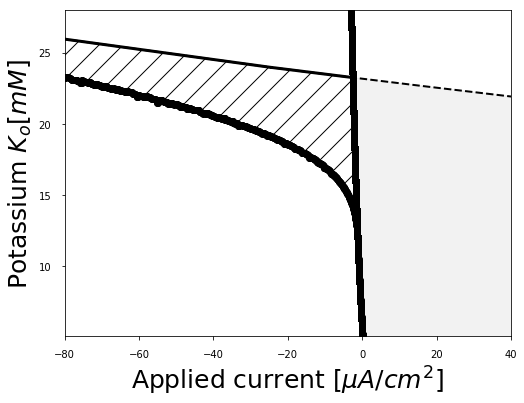

In [17]:
from scipy.interpolate import interp1d
size_axis_font=25
plt.close("all")

fig01 = plt.figure(facecolor="1",figsize=(8,6))
axx = fig01.add_subplot(111)
xlim=[-80,40]
ylim=[5.1,28]
axx.set_xlim(xlim)
axx.set_ylim(ylim)

s_x=1;s_y=0
##### plot sn disappearance, hopf and limit cycle onset
axx.plot(m_res_par_sn_KoIapp[s_x],m_res_par_sn_KoIapp[s_y],'o',color=[0,0,0])
axx.plot(m_res_par_lc_KoIapp[s_x],m_res_par_lc_KoIapp[s_y],'o',color=[0,0,0])
axx.plot(m_res_par_HF0[s_x],m_res_par_HF0[s_y],'--',linewidth=2,color=[0,0,0])

##### Drawing the different regions
a=m_res_par_lc_KoIapp[s_x]
b=m_res_par_sn_KoIapp[s_y]
bx=m_res_par_sn_KoIapp[s_x]
c=m_res_par_HF0[s_x]
cy=m_res_par_HF0[s_y]
f1x = interp1d(m_res_par_sn_KoIapp[s_y][bx.argsort()],bx[bx.argsort()],fill_value=min(m_res_par_sn_KoIapp[s_x]), bounds_error=False)
f2x = interp1d(m_res_par_lc_KoIapp[s_y][a.argsort()],a[a.argsort()],fill_value=min(m_res_par_lc_KoIapp[s_x]), bounds_error=False)
f3x = interp1d(m_res_par_HF0[s_y][c.argsort()],c[c.argsort()],fill_value=min(m_res_par_lc_KoIapp[s_x]), bounds_error=False)
yy=m_res_par_sn_KoIapp[s_x][b.argsort()]
yy2=np.minimum(f3x(b[b.argsort()]),yy)

##### filling the different regions
axx.fill_betweenx(b[b.argsort()],f2x(b[b.argsort()]),yy2,facecolor="none",hatch="/",lw=3., edgecolor='k')
cc=[i for i in b.argsort() if f3x(b[i])>f1x(b[i])]
axx.fill_betweenx(b[cc],f1x(b[cc]),f3x(b[cc]),color='k',alpha=.05)

##### Plot axes
axx.set_ylabel('Potassium $K_o[mM]$',fontsize=size_axis_font)
axx.set_xlabel('Applied current $[\mu A/cm^2]$',fontsize=size_axis_font)
axx.tick_params(axis='y', pad=10)
axx.tick_params(axis='x', pad=10)
plt.show()


# Second.. chapter 3: Sparsly connected networks

## Loading simulation s for different Ko's and extracting stats

In [18]:
from scipy import signal
from scipy.fftpack import fft
import brian2
from brian2.units import *
from brian2 import *
from brianutils import load_model
resol=0.01#ms (min resolution of integration)
from brian2 import units
### For plotting the histograms...
import pandas as pd
import seaborn as sns

units = vars(units)

num_neurons=4000
ge_amp=0.035
gi_amp=0.27
koivv=[8,9,10,11.0,12.0,12.5,13.0, 13.5]
si_v=[1.0]### sigma for white noise approximation..
i_siiv=0
koivv2=np.array(koivv)
# iapi_v=np.array(mu_fr_vect)

iapi_v=np.array([3.44756179, 3.09501356, 2.72745491, 2.34713872, 1.88336673,
       1.64088176, 1.31921738, 0.9238477 ])

# ### Will take as an example Ko 9.5 to see if the deltaU scales with T..

# conds
time_stim=20000

##############################################################333
########### One Run..
model_file='/home/contreras/Documents/Project_Adaptation/network_trial/cfg/MTM_W_sPNAs_Temp_snapshot_wSynInput.json'
fig_wide=12
fig_height=10
size_title_font=20
size_axis_font=20
matplotlib.rc('font', family='sans-serif', size=size_axis_font)

INFO       Cache size for target "cython": 9891 MB.
You can call "clear_cache('cython')" to delete all files from the cache or manually delete files in the "/home/contreras/.cython/brian_extensions" directory. [brian2]


In [19]:
import json
P= json.load(open("cfg/Thesis_mpl.json")) # import plot parameter
matplotlib.rcParams.update([(j,k) for (j,k) in P.items()
                            if j in matplotlib.rcParams.keys()])

d_Network_N_4000_num_runs_1_lengthSim_20000K_o_13_I_app_13ge_3_gi_27pconnect_10_wZoomIn2Volt_multReal_num1wY_presimprPresMas Exists, or is being calculated.. :)


WARNING    /home/contreras/anaconda2/envs/AUTO_py37/lib/python3.7/site-packages/matplotlib/figure.py:445: UserWarning: Matplotlib is currently using module://ipykernel.pylab.backend_inline, which is a non-GUI backend, so cannot show the figure.
  % get_backend())
 [py.warnings]
WARNING    /home/contreras/anaconda2/envs/AUTO_py37/lib/python3.7/site-packages/matplotlib/font_manager.py:1241: UserWarning: findfont: Font family ['sans-serif'] not found. Falling back to DejaVu Sans.
  (prop.get_family(), self.defaultFamily[fontext]))
 [py.warnings]


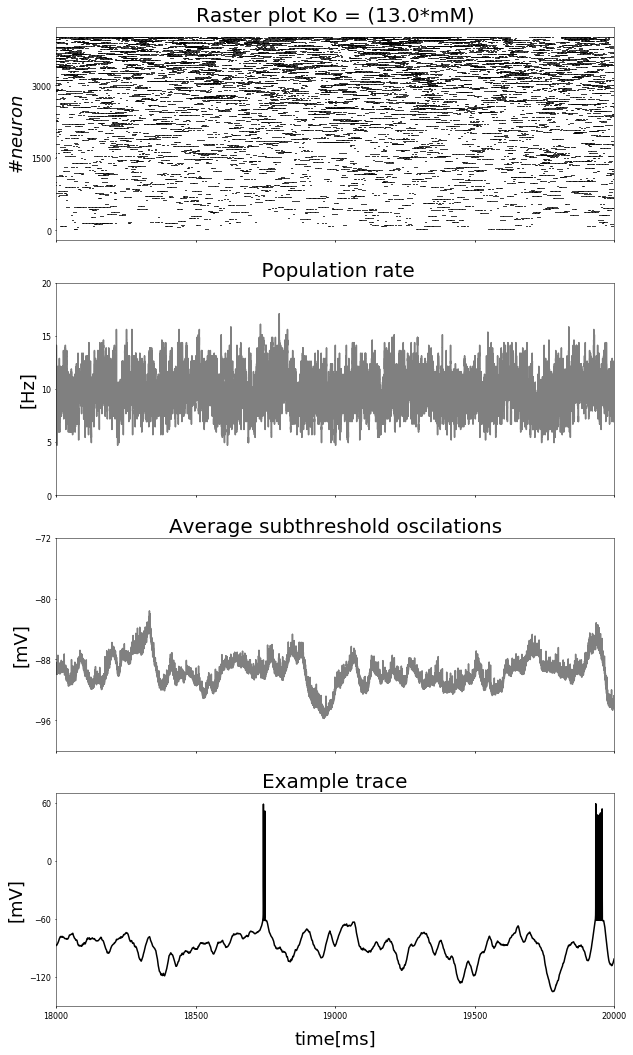

In [20]:
from scipy import signal
fig_wide=10
fig_height=12
size_title_font=20
size_axis_font=18

# ckoi=len(koivv2)-1
# for K_o in koivv2[::-1]:
ckoi=0
for K_o in koivv2:
    if K_o==13:
        iapi=iapi_v[ckoi]
        bifparx={}

        ge_amp=0.035
        gi_amp=0.27
        ############# Creating Fancy name to understand simulations later
        num_runs=1
        ii_num_realizations_4_smooth=1
        num_neurons=4000
        bifparx["I_app"]=[str(iapi)+"* uA/cm2"]#0.87 for low and -0.68 For high to achieve ~10Hz Fr
        bifparx["K_o"]=["("+str(K_o)+"*mM)"]
        ############# Creating Fancy name to understand simulations later
        name='d_Network_N_'+str(num_neurons)+'_num_runs_'+str(1)+'_lengthSim_'+str(int(time_stim))
        iapp='I_app'
        ko='K_o'
        dir_pars=bifparx
        Koi_bifparx=float(dir_pars[ko][0][dir_pars[ko][0].index('(')+1:dir_pars[ko][0].index('*')])
        if Koi_bifparx-int(Koi_bifparx)==0:
            stringi=ko+'_'+str(int(Koi_bifparx))+'_'
        else:
            Koi_bifparx_aux=int((Koi_bifparx-int(Koi_bifparx))*100)
            stringi=ko+'_'+str(int(Koi_bifparx))+'_'+str(Koi_bifparx_aux)+'_'
        stringi=stringi+iapp+'_'+str(int(float(dir_pars[iapp][0][0:dir_pars[iapp][0].index('*')])*10))
        stringi=stringi+'ge_'+str(int(ge_amp*100))+'_gi_'+str(int(gi_amp*100))
        stringi=stringi+'pconnect_'+str(int(10.0))
        stringi=stringi+'_wZoomIn2Volt'
        stringi=stringi+'_multReal_num'+str(ii_num_realizations_4_smooth)+'wY_pres'
        name=name+stringi+'imprPresMas'
        dir_sims='/groups/susanne/Susana/Simulations/Network_trial/'
        if os.path.isfile(dir_sims+name+'.pkl'):
            print(name + ' Exists, or is being calculated.. :)')
            with open(dir_sims+name+'.pkl', "rb") as f:
                dir_i = pickle.load(f)

            f1, ax= plt.subplots(4, sharex=True, facecolor="1",figsize=(fig_wide,fig_height*1.5))
            fr_ini=[]
            t_ini=5000+dir_i[0]['Population_Rate']['t'][0]
            m_trains=dir_i[0]['Spiking']['Trains']
            for ii in range(len(m_trains)):
                fr_ini.append(sum(m_trains[ii]<t_ini))

            ii_sort_Fr=np.argsort(fr_ini)
            bifparx=dir_i[0]['d_Protocol']['bifparx'] 
            ax[0].eventplot(np.array(m_trains)[ii_sort_Fr],linelengths=5.0,color='k',rasterized=True)
            ax[0].set_title(r'Raster plot Ko = '+bifparx["K_o"][0],fontsize=size_title_font)
            ax[0].set_ylabel(r'$\# neuron$',fontsize=size_axis_font)
            locatory0 = MaxNLocator(nbins=4) # with 3 bins you will have 4 ticks
            ax[0].yaxis.set_major_locator(locatory0)
            ax[1].plot(dir_i[0]['Population_Rate']['t'], dir_i[0]['Population_Rate']['Freq_Pop'],color='grey',rasterized=True)
            ax[1].set_title(r' Population rate',fontsize=size_title_font)
            ax[1].set_ylabel(r'[Hz]',fontsize=size_axis_font)
            locatory1 = MaxNLocator(nbins=4) # with 3 bins you will have 4 ticks
            ax[1].yaxis.set_major_locator(locatory1)
            ax[1].set_ylim([0,20])
            ### subthreshold oscillations: 
            ax[2].plot(dir_i[0]['Spiking_zoom']['t'], np.mean(dir_i[0]['Spiking_zoom']['V'],axis=0), color='grey',rasterized=True)
            # ax[2].plot(statemon.t/ms, aM_e,color='r')
            # ax[2].plot(statemon.t/ms, aM_i,color='k')
            ax[2].set_title(r'Average subthreshold oscilations',fontsize=size_title_font)
            ax[2].set_ylabel(r'[mV]',fontsize=size_axis_font)
            # ax[2].set_xlabel(r'time[ms]',fontsize=size_axis_font)
            ax[2].set_ylim([-100,-72])
            locatory2 = MaxNLocator(nbins=4) # with 3 bins you will have 4 ticks
            ax[2].yaxis.set_major_locator(locatory2)
            m_trains=dir_i[0]['Spiking_zoom']['Trains']
            jj=np.argmin(abs(np.mean([len(ii_trains) for ii_trains in m_trains])-[len(ii_trains) for ii_trains in m_trains]))
            ax[3].plot(dir_i[0]['Spiking_zoom']['t'], dir_i[0]['Spiking_zoom']['V'][jj], color='k', label='Neuron '+str(jj),rasterized=True)
            ax[3].set_title(r'Example trace',fontsize=size_title_font)
            ax[3].set_ylabel(r'[mV]',fontsize=size_axis_font)
            ax[3].set_xlabel(r'time[ms]',fontsize=size_axis_font,labelpad=10)
            ax[3].set_ylim([-150,70])
            locatory3 = MaxNLocator(nbins=4) # with 3 bins you will have 4 ticks
            ax[3].yaxis.set_major_locator(locatory3)
            # f1.suptitle('Ko='+str(K_o))
            ######## Saving Fig..
            dir_figs='/home/contreras/Documents/Project_Adaptation/network_trial/Figs/'
            name_file='NetworkRasterPlot_'+str(num_neurons)+'_num_runs_'+str(1)+'_lengthSim_'+str(int(time_stim))+'_'
            iapp='I_app'
            ko='K_o'
            stringi=ko+'_'+str(int(float(bifparx[ko][0][bifparx[ko][0].index('(')+1:bifparx[ko][0].index('*')])))+'_'
            stringi=stringi+iapp+'_'+str(int(float(bifparx[iapp][0][0:bifparx[iapp][0].index('*')])*10))
            stringi=stringi+'ge_'+str(int(ge_amp*100))+'_gi_'+str(int(gi_amp*100))
            name=name_file+stringi
            v_in_degree_E=[]
            v_in_degree_I=[]
            for ii in np.unique(dir_i[0]['J']['J_e'][1]):
                v_in_degree_E.append(sum(np.array(dir_i[0]['J']['J_e'][1])==ii))
                v_in_degree_I.append(sum(np.array(dir_i[0]['J']['J_i'][1])==ii))
            
            fig_file_title='fig_'+name
            md_dir={
                    'Title':'Raster plot',
                    'Author':"Susana Contreras 25/02/2019",
                    'Subject':'Network simulation '+str(num_neurons)+' neurons snapshot with Ko='+str(int(float(bifparx[ko][0][bifparx[ko][0].index('(')+1:bifparx[ko][0].index('*')])))+' '+iapp+'='+dir_pars[iapp][0][0:dir_pars[iapp][0].index('*')]+' C_E='+str(np.mean(v_in_degree_E))+' C_I='+str(np.mean(v_in_degree_I)),
                    'Keywords':"Ko bistability, network synchronization, SNIC, SNL"
                    }
            ax[0].set_xlim(18000,20000)
            locatorx1 = MaxNLocator(nbins=4) # with 3 bins you will have 4 ticks
            ax[3].xaxis.set_major_locator(locatorx1)
            #saving_pdf_figure(f1,dir_figs+fig_file_title,md_dir)
        del(dir_i)
    ckoi+=1
    

f1.show()


In [21]:
import json
P= json.load(open("cfg/Thesis_mpl.json")) # import plot parameter
matplotlib.rcParams.update([(j,k) for (j,k) in P.items()
                            if j in matplotlib.rcParams.keys()])

fig_wide=matplotlib.rcParams["figure.figsize"][0]
fig_height=matplotlib.rcParams["figure.figsize"][1]


In [22]:
K_o=13.0

d_Network_N_4000_num_runs_1_lengthSim_20000K_o_13_I_app_13ge_3_gi_27pconnect_10_wZoomIn2Volt_multReal_num1wY_presExists, or is being calculated.. :)
{'bifparx': {'I_app': ['1.31921738* uA/cm2'], 'K_o': ['(13.0*mM)']}, 'num_neurons': 4000, 'model_file': '/home/contreras/Documents/Project_Adaptation/network_trial/cfg/MTM_W_sPNAs_Temp_snapshot_wSynInput.json'}


WARNING    /home/contreras/anaconda2/envs/AUTO_py37/lib/python3.7/site-packages/ipykernel_launcher.py:60: VisibleDeprecationWarning: Passing `normed=True` on non-uniform bins has always been broken, and computes neither the probability density function nor the probability mass function. The result is only correct if the bins are uniform, when density=True will produce the same result anyway. The argument will be removed in a future version of numpy.
 [py.warnings]


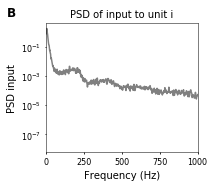

In [23]:
# Now we will find the power spectrum and check if it is slow enough to assume that for some inputs  the unit reached the steady state..
name='d_Network_N_'+str(num_neurons)+'_num_runs_'+str(1)+'_lengthSim_'+str(int(time_stim))
iapp='I_app'
ko='K_o'
dir_pars=bifparx
Koi_bifparx=float(dir_pars[ko][0][dir_pars[ko][0].index('(')+1:dir_pars[ko][0].index('*')])
if Koi_bifparx-int(Koi_bifparx)==0:
    stringi=ko+'_'+str(int(Koi_bifparx))+'_'
else:
    Koi_bifparx_aux=int((Koi_bifparx-int(Koi_bifparx))*100)
    stringi=ko+'_'+str(int(Koi_bifparx))+'_'+str(Koi_bifparx_aux)+'_'
stringi=stringi+iapp+'_'+str(int(float(dir_pars[iapp][0][0:dir_pars[iapp][0].index('*')])*10))
stringi=stringi+'ge_'+str(int(ge_amp*100))+'_gi_'+str(int(gi_amp*100))
stringi=stringi+'pconnect_'+str(int(10.0))
stringi=stringi+'_wZoomIn2Volt'
stringi=stringi+'_multReal_num'+str(ii_num_realizations_4_smooth)+'wY_pres'
name=name+stringi
dir_sims='/groups/susanne/Susana/Simulations/Network_trial/'

if os.path.isfile(dir_sims+name+'.pkl'):
    print(name + 'Exists, or is being calculated.. :)')
    f=open(dir_sims+name+'.pkl', 'rb')
    dir_i=pickle.load(f)
    # 2. extract data, most relevant.. specific inputs to each of the cells..
    iij=0
    tzoom=dir_i[iij]['Spiking_zoom']['t']
    vzoom=dir_i[iij]['Spiking_zoom']['V']
    a_y=dir_i[iij]['Spiking_zoom']['y']
    ge=dir_i[iij]['Spiking_zoom']['ge']
    gi=dir_i[iij]['Spiking_zoom']['gi']
    trains_zoom=dir_i[iij]['Spiking_zoom']['Trains']
    aw_pos_pop=dir_i[iij]['Spiking_zoom']['input_distribution_2all']['a']
    bw_pos_pop=dir_i[iij]['Spiking_zoom']['input_distribution_2all']['b']
    v_l0i=dir_i[iij]['Spiking_zoom']['input_distribution_2all']['l0']
    v_ys_0i=dir_i[iij]['Spiking_zoom']['input_distribution_2all']['ys_0']
    v_LC0i=dir_i[iij]['Spiking_zoom']['input_distribution_2all']['v_LC0']
    v_saddlei=dir_i[iij]['Spiking_zoom']['input_distribution_2all']['v_saddle']
    v_stablei=dir_i[iij]['Spiking_zoom']['input_distribution_2all']['v_stable']
    t_I_app_specf_pop_0i=dir_i[iij]['Spiking_zoom']['input_distribution_2all']['I_app_specf_pop_0']
    dir_pars=dir_i[iij]['d_Protocol']['bifparx']
    print(dir_i[iij]['d_Protocol'])
    x_inp=[]
    x_mean_inp=[]
    x_var_inp=[]
    trains_each_i=[]
    for ii_zooms in range(len(vzoom)):
        xi=gi[ii_zooms]*2+ge[ii_zooms]*2+iapi## This comes from the conductance of each synapse (2mS)
        x_inp.append(xi)
        x_mean_inp.append(np.mean(xi))
        x_var_inp.append(np.var(xi))
        trains_each_i.append(trains_zoom[ii_zooms])
        
    ### First I will take as an example the median..although.. this is not so relevant..except for the mean, which is not interesting at all
    ##THis was the closest to the median for all neurons.. but I'm choosing one that illustrates everything better
    #i_unit=np.array(range(len(x_mean_inp)))[np.argmin(np.abs(x_mean_inp-np.median(x_mean_inp)))]
    nbins=5 ## THis determines the precision of the states where the unit layed
    #### Neurons that can illustrate the whole range of dyns with the bins chosen..
    useful_neurons=[]
    for i_unit in range(len(x_inp)):
        count, bins  = np.histogram(x_inp[i_unit],bins=nbins, normed=True)
        if len([bini for bini in bins if (bini>f2x(K_o))*(bini<f1x(K_o))])>0 and len([bini for bini in bins if (bini>f1x(K_o))])>0:
            useful_neurons.append(i_unit)

    i_unit=np.array(useful_neurons)[np.argmin(np.abs(np.array(x_mean_inp)[useful_neurons]-np.median(x_mean_inp)))]

   
x=x_inp[i_unit]
fs=len(x)/((tzoom[-1]-tzoom[0])/1000.0)## To have sample  frequency in Hz
sliding_window=int(fs/1.0)#To get a 2.0Hz resolution
overlap = 0.0
n_overlap = int(sliding_window * overlap)
f_lfp, p_lfp = signal.welch(x-mean(x), fs,'flattop',nperseg=sliding_window, noverlap=n_overlap,scaling='spectrum')

f11, ax= plt.subplots(1, sharex=True,sharey=True, facecolor="1",figsize=(fig_wide*0.5,fig_height*0.5))


ax.semilogy(f_lfp,p_lfp,label='$ < input > $'+str(x_mean_inp[i_unit]),color='grey')

ax.set_title('PSD of input to unit i')
ax.set_xlabel('Frequency (Hz)')
ax.set_ylabel('PSD input')
ax.set_xlim(0,1000)

iapp='I_app'
ko='K_o'
Koi_bifparx=float(dir_pars[ko][0][dir_pars[ko][0].index('(')+1:dir_pars[ko][0].index('*')])
if Koi_bifparx-int(Koi_bifparx)==0:
    stringi=ko+'_'+str(int(Koi_bifparx))+'_'
else:
    Koi_bifparx_aux=int((Koi_bifparx-int(Koi_bifparx))*100)
    stringi=ko+'_'+str(int(Koi_bifparx))+'_'+str(Koi_bifparx_aux)+'_'
stringi=stringi+iapp+'_'+str(int(float(dir_pars[iapp][0][0:dir_pars[iapp][0].index('*')])*10))
stringi=stringi+'ge_'+str(int(ge_amp*100))+'_gi_'+str(int(gi_amp*100))


name_file='PSD_Input2Neuroni_'+str(num_neurons)+'_num_runs_'+str(1)+'_lengthSim_'+str(int(time_stim))+'_'
name_i=name_file+stringi

fig_file_title='fig_'+name_i
md_dir={
        'Title':'PSD input to neuron i',
        'Author':"Susana Contreras 25/02/2019",
        'Subject':'Network simulation '+str(num_neurons)+' neurons snapshot with Ko='+str(int(float(bifparx[ko][0][bifparx[ko][0].index('(')+1:bifparx[ko][0].index('*')])))+' '+iapp+'='+dir_pars[iapp][0][0:dir_pars[iapp][0].index('*')]+' C_E='+str(np.mean(v_in_degree_E))+' C_I='+str(np.mean(v_in_degree_I)),
        'Keywords':"Ko bistability, network synchronization, SNIC, SNL"
        }

locatorx1 = MaxNLocator(nbins=4) # with 3 bins you will have 4 ticks
ax.xaxis.set_major_locator(locatorx1)

box0=ax.get_position()

d_boxy=0.05
d_boxx=0.07
ax.set_position([box0.x0+d_boxx, box0.y0+d_boxy, box0.width*0.95, box0.height*0.95])


import string
# for n, axs in enumerate(ax.flat):   
ax.text(-0.26, 1.05, string.ascii_uppercase[1], transform=ax.transAxes, 
        size=matplotlib.rcParams["font.size"], weight='bold')

dir_figs='/home/contreras/Documents/Project_Adaptation/network_trial/Figs/'
# saving_pdf_figure(f11,dir_figs+fig_file_title,md_dir)
# saving_pdf_figure(f11,'./Figs/'+fig_file_title,md_dir)
## The power spectrum decays fast.. so I will assume I can split the inputs, and assume that the neuron can reach the stable state before the input changed.. (later I will have to discuss on this regard)

WARNING    /home/contreras/anaconda2/envs/AUTO_py37/lib/python3.7/site-packages/ipykernel_launcher.py:44: UserWarning: Attempted to set non-positive left xlim on a log-scaled axis.
Invalid limit will be ignored.
 [py.warnings]


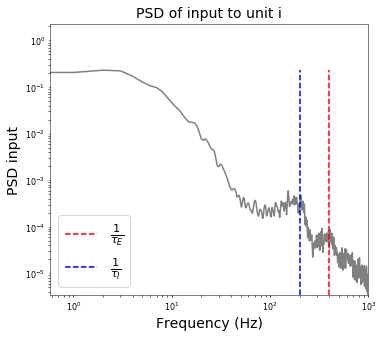

In [24]:
f11, ax= plt.subplots(1, sharex=True,sharey=True, facecolor="1",figsize=(fig_wide,fig_height))


Norm=np.var(x-mean(x))/(2*np.trapz(p_lfp,x=f_lfp))
ax.loglog(f_lfp,Norm*p_lfp,color='grey')

ax.set_title('PSD of input to unit i',fontsize=14)
ax.set_xlabel('Frequency (Hz)',fontsize=14)
ax.set_ylabel('PSD input',fontsize=14)

iapp='I_app'
ko='K_o'
Koi_bifparx=float(dir_pars[ko][0][dir_pars[ko][0].index('(')+1:dir_pars[ko][0].index('*')])
if Koi_bifparx-int(Koi_bifparx)==0:
    stringi=ko+'_'+str(int(Koi_bifparx))+'_'
else:
    Koi_bifparx_aux=int((Koi_bifparx-int(Koi_bifparx))*100)
    stringi=ko+'_'+str(int(Koi_bifparx))+'_'+str(Koi_bifparx_aux)+'_'
stringi=stringi+iapp+'_'+str(int(float(dir_pars[iapp][0][0:dir_pars[iapp][0].index('*')])*10))
stringi=stringi+'ge_'+str(int(ge_amp*100))+'_gi_'+str(int(gi_amp*100))


name_file='PSD_Input2Neuroni_'+str(num_neurons)+'_num_runs_'+str(1)+'_lengthSim_'+str(int(time_stim))+'_'
name_i=name_file+stringi

fig_file_title='fig_'+name_i
md_dir={
        'Title':'PSD input to neuron i',
        'Author':"Susana Contreras 25/02/2019",
        'Subject':'Network simulation '+str(num_neurons)+' neurons snapshot with Ko='+str(int(float(bifparx[ko][0][bifparx[ko][0].index('(')+1:bifparx[ko][0].index('*')])))+' '+iapp+'='+dir_pars[iapp][0][0:dir_pars[iapp][0].index('*')]+' C_E='+str(np.mean(v_in_degree_E))+' C_I='+str(np.mean(v_in_degree_I)),
        'Keywords':"Ko bistability, network synchronization, SNIC, SNL"
        }

# locatorx1 = MaxNLocator(nbins=4) # with 3 bins you will have 4 ticks
# ax.xaxis.set_major_locator(locatorx1)

tau_E=5.0#ms
tau_I=10#ms

ax.plot([2/(tau_E/1000.0), 2/(tau_E/1000.0)],[min(Norm*np.array(p_lfp[f_lfp<1000])),max(Norm*np.array(p_lfp))],'--',color='r',label=r'$\frac{1}{\tau_E}$')
ax.plot([2/(tau_I/1000.0), 2/(tau_I/1000.0)],[min(Norm*np.array(p_lfp[f_lfp<1000])),max(Norm*np.array(p_lfp[f_lfp<1000]))],'--',color='b',label=r'$\frac{1}{\tau_I}$')


ax.set_xlim(0,1000)
ax.set_ylim(min(Norm*np.array(p_lfp[f_lfp<1000])),max(Norm*np.array(p_lfp[f_lfp<1000]))*10)

ax.legend(fontsize=16)

Text(-0.26, 1.05, 'C')

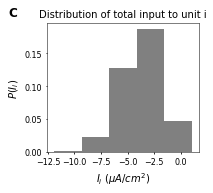

In [25]:
## Anyhow, now, I just need to calculate the histogram of the input, to know where this particular unit lies in the bif graph..

plt.close("all")
f21, ax= plt.subplots(1, sharex=True,sharey=True, facecolor="1",figsize=(fig_wide*0.5,fig_height*0.5))
aw_pos,bw_pos,cw_pos=ax.hist(x_inp[i_unit],bins=nbins,label='$ < input > $'+str(x_mean_inp[i_unit]),density=True, color='grey')## here a will give the weighting for each state, or the proportion of times when the unit was there, and b will give the actual currents
# aw_pos,bw_pos,cw_pos=ax.hist(x_inp[i_unit],bins=nbins,label='$ < input > $'+str(x_mean_inp[i_unit]))## here a will give the weighting for each state, or the proportion of times when the unit was there, and b will give the actual currents

ax.set_xlabel(r'$I_i$ $(\mu A / cm^2)$')
ax.set_ylabel(r'$P(I_i)$ ')
ax.set_title('Distribution of total input to unit i')



name_file='D_intensity_Input2Neuroni_'+str(num_neurons)+'_num_runs_'+str(1)+'_lengthSim_'+str(int(time_stim))+'_'
name_i=name_file+stringi

fig_file_title='fig_'+name_i
md_dir={
        'Title':'distribution of Intensity of input to neuron i',
        'Author':"Susana Contreras 25/02/2019",
        'Subject':'Network simulation '+str(num_neurons)+' neurons snapshot with Ko='+str(int(float(bifparx[ko][0][bifparx[ko][0].index('(')+1:bifparx[ko][0].index('*')])))+' '+iapp+'='+dir_pars[iapp][0][0:dir_pars[iapp][0].index('*')]+' C_E='+str(np.mean(v_in_degree_E))+' C_I='+str(np.mean(v_in_degree_I)),
        'Keywords':"Ko bistability, network synchronization, SNIC, SNL"
        }

locatory1 = MaxNLocator(nbins=4) # with 3 bins you will have 4 ticks
ax.yaxis.set_major_locator(locatory1)

box0=ax.get_position()
d_boxy=0.05
d_boxx=0.07
ax.set_position([box0.x0+d_boxx, box0.y0+d_boxy, box0.width*0.95, box0.height*0.95])


import string
# for n, axs in enumerate(ax.flat):   
ax.text(-0.26, 1.05, string.ascii_uppercase[2], transform=ax.transAxes, 
        size=matplotlib.rcParams["font.size"], weight='bold')

# saving_pdf_figure(f21,dir_figs+fig_file_title,md_dir)
# saving_pdf_figure(f21,'./Figs/'+fig_file_title,md_dir)

# saving_pdf_figure(f21,dir_figs+fig_file_title,md_dir)

WARNING    /home/contreras/anaconda2/envs/AUTO_py37/lib/python3.7/site-packages/matplotlib/tight_layout.py:211: UserWarning: Tight layout not applied. tight_layout cannot make axes height small enough to accommodate all axes decorations
  warnings.warn('Tight layout not applied. '
 [py.warnings]


Text(-0.25, 1.05, 'A')

<Figure size 410.4x108 with 0 Axes>

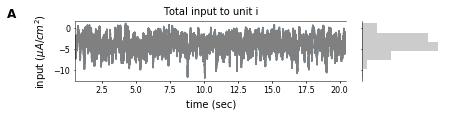

In [26]:
f21 = plt.figure(facecolor="1",figsize=(fig_wide,0.3*fig_height))

grid = sns.JointGrid(tzoom/1000.0,x_inp[i_unit], ratio=3)
grid.plot_joint(plt.plot)
grid.ax_joint.plot(tzoom/1000.0,x_inp[i_unit],color='grey')

plt.sca(grid.ax_marg_y)
sns.distplot(grid.y, kde=False, vertical=True, bins=nbins+1,color='grey')

# override a bunch of the default JointGrid style options
grid.fig.set_size_inches(fig_wide,0.25*fig_height)
grid.ax_marg_x.remove()
grid.ax_joint.spines['top'].set_visible(True)

grid.ax_joint.set_xlabel('time (sec)')
grid.ax_joint.set_ylabel(r'input $(\mu A / cm^2)$')
grid.ax_joint.set_title(r'Total input to unit i')
grid.ax_joint.set_xlim(0.500,20.500)
plt.tight_layout()

f21=grid

name_file='Input2Neuroni_'+str(num_neurons)+'_num_runs_'+str(1)+'_lengthSim_'+str(int(time_stim))+'_'
name_i=name_file+stringi

fig_file_title='fig_'+name_i
md_dir={
        'Title':'input to neuron i',
        'Author':"Susana Contreras 25/02/2019",
        'Subject':'Network simulation '+str(num_neurons)+' neurons snapshot with Ko='+str(int(float(bifparx[ko][0][bifparx[ko][0].index('(')+1:bifparx[ko][0].index('*')])))+' '+iapp+'='+dir_pars[iapp][0][0:dir_pars[iapp][0].index('*')]+' C_E='+str(np.mean(v_in_degree_E))+' C_I='+str(np.mean(v_in_degree_I)),
        'Keywords':"Ko bistability, network synchronization, SNIC, SNL"
        }

import string
# for n, axs in enumerate(ax.flat):   
grid.ax_joint.text(-0.25, 1.05, string.ascii_uppercase[0], transform=grid.ax_joint.transAxes, 
        size=matplotlib.rcParams["font.size"], weight='bold')


# locatory1 = MaxNLocator(nbins=4) # with 3 bins you will have 4 ticks
# ax.yaxis.set_major_locator(locatory1)

# saving_pdf_figure(f21,dir_figs+fig_file_title,md_dir)
# saving_pdf_figure(f21,'./Figs/'+fig_file_title,md_dir)

In [27]:
fig_file_title

'fig_Input2Neuroni_4000_num_runs_1_lengthSim_20000_K_o_13_I_app_13ge_3_gi_27'

# Now we want to extract phase planes in each of the regions

In [30]:
t_I_app_specf_calc=t_I_app_specf_pop_0i[::10]+[t_I_app_specf_pop_0i[-1]]
if K_o>12.0 and sum((t_I_app_specf_calc>f2x(K_o))*(t_I_app_specf_calc<f1x(K_o)))<4:
    t_I_app_specf_calc=t_I_app_specf_calc+[3.9*(f1x(K_o)-f2x(K_o))/4+f2x(K_o)]
    t_I_app_specf_calc=t_I_app_specf_calc+[3*(f1x(K_o)-f2x(K_o))/4+f2x(K_o)]
    t_I_app_specf_calc=t_I_app_specf_calc+[2*(f1x(K_o)-f2x(K_o))/4+f2x(K_o)]
    t_I_app_specf_calc=t_I_app_specf_calc+[1.1*(f1x(K_o)-f2x(K_o))/4+f2x(K_o)]

if K_o==12.0 and sum((t_I_app_specf_calc>f2x(K_o))*(t_I_app_specf_calc<f1x(K_o)))<2:
    t_I_app_specf_calc=t_I_app_specf_calc+[3*(f1x(K_o)-f2x(K_o))/4+f2x(K_o)]
    t_I_app_specf_calc=t_I_app_specf_calc+[2*(f1x(K_o)-f2x(K_o))/4+f2x(K_o)]

## Comment if not so precise..
if sum((t_I_app_specf_calc>f1x(K_o)))<5:
    t_I_app_specf_calc=t_I_app_specf_calc+[ii_iap_calc for ii_iap_calc in t_I_app_specf_pop_0i if ii_iap_calc>f1x(K_o)]
        
t_I_app_specf_calc=list(np.sort(t_I_app_specf_calc))
t_I_app_specf=t_I_app_specf_calc

I_app_vv=t_I_app_specf_calc

# v_iapp=t_I_app_specf_calc

v_iapp=bw_pos

In [31]:
def fl0ys0i_sn_st_lc(Iiapi):
    ii_tiap_specf=np.argmin(abs(t_I_app_specf_pop_0i-Iiapi))
    l0i=v_l0i[ii_tiap_specf]
    ys_0i=v_ys_0i[ii_tiap_specf]
    saddlei=v_saddlei[ii_tiap_specf]
    stablei=v_stablei[ii_tiap_specf]
    LC0i=v_LC0i[ii_tiap_specf]
    cci=1
    while len(l0i)<1 and cci<ii_tiap_specf:
        l0i=v_l0i[ii_tiap_specf-cci]
        ys_0i=v_ys_0i[ii_tiap_specf-cci]
        cci+=1

    if cci>1:
        if np.argmin(np.dot(l0i,v_LC0i[ii_tiap_specf])-ys_0i)==np.argmax(abs(np.dot(l0i,v_LC0i[ii_tiap_specf])-ys_0i)):
            l0i=-l0i
            ys_0i=-ys_0i

    return(l0i,ys_0i,saddlei,stablei,LC0i)

# Results: Phase planes in each of the regions

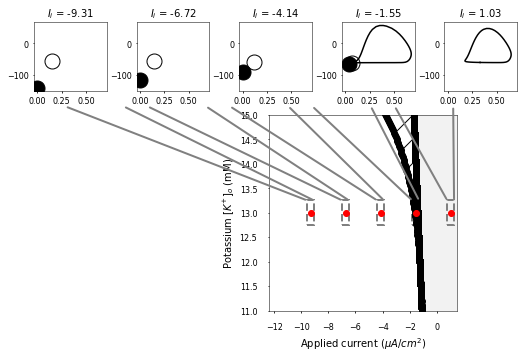

In [32]:
plt.close("all")
# n_splts=np.min([len(t_I_app_specf),5])
n_splts=int(len(v_iapp)/1)

fig01 = plt.figure(facecolor="1",figsize=(fig_wide*(1+n_splts*0.1),fig_height*(1+n_splts*0.01)))

axpl = plt.subplot2grid((50,4*n_splts), (16, int(4*(n_splts-1)-int(3*n_splts/2))), colspan=int(3*n_splts/2),rowspan=34)
ax=[]
for ii_iapi in range(len(v_iapp[::int(len(v_iapp)/n_splts)][:-1])):
    if ii_iapi>0:
        ax.append(plt.subplot2grid((50,4*(n_splts-1)), (0, ii_iapi*4), colspan=3,rowspan=12,sharex=ax[0],sharey=ax[0]))
    else:
        ax.append(plt.subplot2grid((50,4*(n_splts-1)), (0, ii_iapi*4), colspan=3,rowspan=12))
        
axpl.set_xlim([min(v_iapp)-0.5,max(v_iapp)+0.5])       
axpl.set_ylim([K_o-2.0,15])


s_x=1;s_y=0
##### plot sn disappearance, hopf and limit cycle onset
axpl.plot(m_res_par_sn_KoIapp[s_x],m_res_par_sn_KoIapp[s_y],'o',color=[0,0,0])
axpl.plot(m_res_par_lc_KoIapp[s_x],m_res_par_lc_KoIapp[s_y],'o',color=[0,0,0])
axpl.plot(m_res_par_HF0[s_x],m_res_par_HF0[s_y],'--',linewidth=2,color=[0,0,0])

##### Drawing the different regions
a=m_res_par_lc_KoIapp[s_x]
b=m_res_par_sn_KoIapp[s_y]
bx=m_res_par_sn_KoIapp[s_x]
c=m_res_par_HF0[s_x]
cy=m_res_par_HF0[s_y]
f1x = interp1d(m_res_par_sn_KoIapp[s_y][bx.argsort()],bx[bx.argsort()],fill_value=min(m_res_par_sn_KoIapp[s_x]), bounds_error=False)
f2x = interp1d(m_res_par_lc_KoIapp[s_y][a.argsort()],a[a.argsort()],fill_value=min(m_res_par_lc_KoIapp[s_x]), bounds_error=False)
f3x = interp1d(m_res_par_HF0[s_y][c.argsort()],c[c.argsort()],fill_value=min(m_res_par_lc_KoIapp[s_x]), bounds_error=False)
yy=m_res_par_sn_KoIapp[s_x][b.argsort()]
yy2=np.minimum(f3x(b[b.argsort()]),yy)
axpl.fill_betweenx(b[b.argsort()],f2x(b[b.argsort()]),yy2,facecolor="none",hatch="/",lw=3., edgecolor='k')
cc=[i for i in b.argsort() if f3x(b[i])>f1x(b[i])]
axpl.fill_betweenx(b[cc],f1x(b[cc]),f3x(b[cc]),color='k',alpha=.05)
##### Plot axes
axpl.set_ylabel('Potassium $[K^{+}]_o$ (mM)')
axpl.set_xlabel('Applied current $(\mu A/cm^2)$')
axpl.tick_params(axis='y', pad=10)
axpl.tick_params(axis='x', pad=10)


###### Phase planes
for ii_iapi,I_iapi in enumerate(v_iapp[::int(len(v_iapp)/n_splts)][1:]):
    ### Plot limit cycle onset
    l0i,ys_0i,saddle,stable,limit_cycle=fl0ys0i_sn_st_lc(I_iapi)
#     ax[ii_iapi].set_title(strIapp+" = "+ "{:.2f}".format(I_iapi))
    ax[ii_iapi].set_title("$I_i$ = "+ "{:.2f}".format(I_iapi))
#     for ii_api_lc in range(len(v_I_app)):
    try:
        ax[ii_iapi].plot(limit_cycle[1],limit_cycle[0],color='black')
    except:
        try:
            for ii_limi in v_LC0i[::-1]:
                if len(ii_limi)>0:
                    limit_cycle_g=ii_limi
          
            #ax[ii_iapi].plot(limit_cycle_g[1],limit_cycle_g[0],'--',color='black')
        except:
            pass
        pass

    try:
        ax[ii_iapi].plot(saddle[1],saddle[0],'o',markersize=15,mfc='none',color='black')
    except:
        pass

    try:
        ax[ii_iapi].plot(stable[1],stable[0],'o',markersize=15,color='black')
    except:
        pass
    

#     ax[ii_iapi].set_ylabel('$'+v_one_sim_s[ii_iapi][0]+'$')
#     ax[ii_iapi].set_xlabel('$'+v_one_sim_s[ii_iapi][1]+'$')
    axpl.plot(I_iapi,K_o,'o',color='r')
    zoomingBox_4PhasePlane(axpl, np.array([I_iapi-0.25,I_iapi+0.25,K_o-0.25,K_o+0.25]), ax[ii_iapi],color='grey')


iapp='I_app'
ko='K_o'
Koi_bifparx=float(dir_pars[ko][0][dir_pars[ko][0].index('(')+1:dir_pars[ko][0].index('*')])
if Koi_bifparx-int(Koi_bifparx)==0:
    stringi=ko+'_'+str(int(Koi_bifparx))+'_'
else:
    Koi_bifparx_aux=int((Koi_bifparx-int(Koi_bifparx))*100)
    stringi=ko+'_'+str(int(Koi_bifparx))+'_'+str(Koi_bifparx_aux)+'_'
stringi=stringi+iapp+'_'+str(int(float(dir_pars[iapp][0][0:dir_pars[iapp][0].index('*')])*10))
stringi=stringi+'ge_'+str(int(ge_amp*100))+'_gi_'+str(int(gi_amp*100))


name_file='Phase_diagrams_neuroni_'+str(num_neurons)+'_num_runs_'+str(1)+'_lengthSim_'+str(int(time_stim))+'_'
name_i=name_file+stringi

fig_file_title='fig_'+name_i
md_dir={
        'Title':'phase diagrams relative 2 bistable region',
        'Author':"Susana Contreras 25/02/2019",
        'Subject':'Network simulation '+str(num_neurons)+' neurons snapshot with Ko='+str(int(float(bifparx[ko][0][bifparx[ko][0].index('(')+1:bifparx[ko][0].index('*')])))+' '+iapp+'='+dir_pars[iapp][0][0:dir_pars[iapp][0].index('*')]+' C_E='+str(np.mean(v_in_degree_E))+' C_I='+str(np.mean(v_in_degree_I)),
        'Keywords':"Ko bistability, network synchronization, SNIC, SNL,concentration dynamics, spiking statistics"
        }

# locatory1 = MaxNLocator(nbins=4) # with 3 bins you will have 4 ticks
# ax.yaxis.set_major_locator(locatory1)

# saving_pdf_figure(fig01,dir_figs+fig_file_title,md_dir)    
    


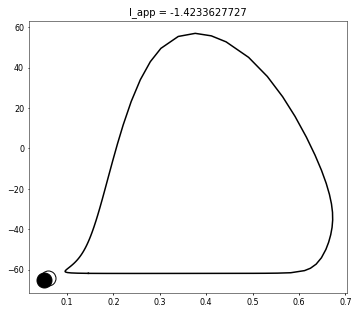

In [33]:
ii_iapi=np.argmin(abs(t_I_app_specf_pop_0i-f1x(K_o)))-1
if t_I_app_specf_pop_0i[ii_iapi]>=f1x(K_o):
    ii_iapi=ii_iapi-1
### Plot limit cycle onset
I_iapi=t_I_app_specf_pop_0i[ii_iapi]
l0i,ys_0i,saddle,stable,limit_cycle=fl0ys0i_sn_st_lc(I_iapi)
plt.title(strIapp+' = '+ str(I_iapi))
#     for ii_api_lc in range(len(v_I_app)):


try:
    plt.plot(limit_cycle[1],limit_cycle[0],color='black')
except:
    try:
        for ii_limi in v_LC0i[::-1]:
            if len(ii_limi)>0:
                limit_cycle_g=ii_limi

        plt.plot(limit_cycle_g[1],limit_cycle_g[0],'--',color='black')
    except:
        pass
    pass


try:
    plt.plot(saddle[1],saddle[0],'o',markersize=15,mfc='none',color='black')
except:
    pass


try:
    plt.plot(stable[1],stable[0],'o',markersize=15,color='black')
except:
    pass

# plt.plot(np.dot(l0i,limit_cycle_g)-ys_0i,'o')
# plt.hist(np.dot(l0i,limit_cycle_g)-ys_0i,bins=np.linspace(-30,30,500))

In [34]:
K_o

13.0

SIM_MTM_W_sPNAs_Temp_snapshot_p0_I_app_-1.18503061999_K_o_13.0_sigma_1.0.pkl
['v', 'n_K', 'm_Na', 'h_Na', 't']
SIM_MTM_W_sPNAs_Temp_snapshot_p0_I_app_0.48462497538_K_o_13.0_sigma_1.0.pkl
['v', 'n_K', 'm_Na', 'h_Na', 't']
SIM_MTM_W_sPNAs_Temp_snapshot_p0_I_app_0.63394018161_K_o_13.0_sigma_1.0.pkl
['v', 'n_K', 'm_Na', 'h_Na', 't']
SIM_MTM_W_sPNAs_Temp_snapshot_p0_I_app_-11.90853714189_K_o_13.0_sigma_1.0.pkl
['v', 'n_K', 'm_Na', 'h_Na', 't']
SIM_MTM_W_sPNAs_Temp_snapshot_p0_I_app_-1.4123627727_K_o_13.0_sigma_1.0.pkl
['v', 'n_K', 'm_Na', 'h_Na', 't']
SIM_MTM_W_sPNAs_Temp_snapshot_p0_I_app_-25.29780002184_K_o_13.0_sigma_1.0.pkl
['v', 'n_K', 'm_Na', 'h_Na', 't']
SIM_MTM_W_sPNAs_Temp_snapshot_p0_I_app_1.23120100654_K_o_13.0_sigma_1.0.pkl
['v', 'n_K', 'm_Na', 'h_Na', 't']
SIM_MTM_W_sPNAs_Temp_snapshot_p0_I_app_-1.32281663314_K_o_13.0_sigma_1.0.pkl
['v', 'n_K', 'm_Na', 'h_Na', 't']
SIM_MTM_W_sPNAs_Temp_snapshot_p0_I_app_0.93257059408_K_o_13.0_sigma_1.0.pkl
['v', 'n_K', 'm_Na', 'h_Na', 't']
SIM_

['v', 'n_K', 'm_Na', 'h_Na', 't']
SIM_MTM_W_sPNAs_Temp_snapshot_p0_I_app_1.50166698969_K_o_13.0_sigma_1.0.pkl
['v', 'n_K', 'm_Na', 'h_Na', 't']
SIM_MTM_W_sPNAs_Temp_snapshot_p0_I_app_0.61901585756_K_o_13.0_sigma_1.0.pkl
['v', 'n_K', 'm_Na', 'h_Na', 't']
SIM_MTM_W_sPNAs_Temp_snapshot_p0_I_app_1.36132264316_K_o_13.0_sigma_1.0.pkl
['v', 'n_K', 'm_Na', 'h_Na', 't']
SIM_MTM_W_sPNAs_Temp_snapshot_p0_I_app_1.14860653684_K_o_13.0_sigma_1.0.pkl
['v', 'n_K', 'm_Na', 'h_Na', 't']
SIM_MTM_W_sPNAs_Temp_snapshot_p0_I_app_-1.91042883002_K_o_13.0_sigma_1.0.pkl
['v', 'n_K', 'm_Na', 'h_Na', 't']
SIM_MTM_W_sPNAs_Temp_snapshot_p0_I_app_-2.94962476796_K_o_13.0_sigma_1.0.pkl
['v', 'n_K', 'm_Na', 'h_Na', 't']
SIM_MTM_W_sPNAs_Temp_snapshot_p0_I_app_1.32513676326_K_o_13.0_sigma_1.0.pkl
['v', 'n_K', 'm_Na', 'h_Na', 't']
SIM_MTM_W_sPNAs_Temp_snapshot_p0_I_app_1.48318239198_K_o_13.0_sigma_1.0.pkl
['v', 'n_K', 'm_Na', 'h_Na', 't']
SIM_MTM_W_sPNAs_Temp_snapshot_p0_I_app_-0.87981132304_K_o_13.0_sigma_1.0.pkl
['v', '

['v', 'n_K', 'm_Na', 'h_Na', 't']
SIM_MTM_W_sPNAs_Temp_snapshot_p0_I_app_0.39434543444_K_o_13.0_sigma_1.0.pkl
['v', 'n_K', 'm_Na', 'h_Na', 't']
SIM_MTM_W_sPNAs_Temp_snapshot_p0_I_app_-1.32073164920_K_o_13.0_sigma_1.0.pkl
['v', 'n_K', 'm_Na', 'h_Na', 't']
SIM_MTM_W_sPNAs_Temp_snapshot_p0_I_app_-0.56058146825_K_o_13.0_sigma_1.0.pkl
['v', 'n_K', 'm_Na', 'h_Na', 't']
SIM_MTM_W_sPNAs_Temp_snapshot_p0_I_app_0.18599456292_K_o_13.0_sigma_1.0.pkl
['v', 'n_K', 'm_Na', 'h_Na', 't']
SIM_MTM_W_sPNAs_Temp_snapshot_p0_I_app_-0.26195105578_K_o_13.0_sigma_1.0.pkl
['v', 'n_K', 'm_Na', 'h_Na', 't']
SIM_MTM_W_sPNAs_Temp_snapshot_p0_I_app_-0.79322595386_K_o_13.0_sigma_1.0.pkl
['v', 'n_K', 'm_Na', 'h_Na', 't']
SIM_MTM_W_sPNAs_Temp_snapshot_p0_I_app_-1.90441832434_K_o_13.0_sigma_1.0.pkl
['v', 'n_K', 'm_Na', 'h_Na', 't']
SIM_MTM_W_sPNAs_Temp_snapshot_p0_I_app_0.72083581713_K_o_13.0_sigma_1.0.pkl
['v', 'n_K', 'm_Na', 'h_Na', 't']
SIM_MTM_W_sPNAs_Temp_snapshot_p0_I_app_-6.52145664393_K_o_13.0_sigma_1.0.pkl
['v'

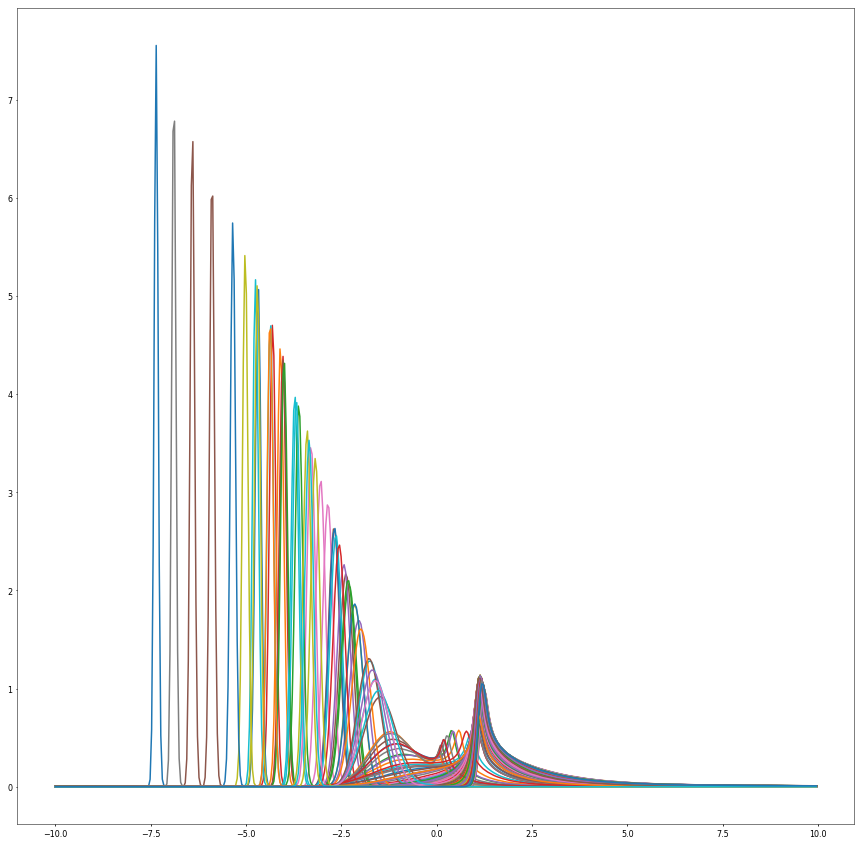

In [35]:
fig01 = plt.figure(facecolor="1",figsize=(15,15))
axp0 = plt.subplot2grid((1,1), (0, 0))

dir_sims_ISI='/groups/susanne/Susana/Simulations/Network_trial/'
jet= plt.get_cmap('summer')
colors = iter(jet(np.linspace(0.2,0.8,len(t_I_app_specf_calc))))

al0_v=[]
bl0_v=[]
lam_0_v=[]
lam_st_v=[]
lam_lc_v=[]
yn_v=[]
ys0_v=[]
y_lc_v=[]
tau_lc_v=[]
int_PRC_v=[]

aa_l0=[]
ci_iapi=0

sigma_v=[1.0,0,0,0]
I_app_vv=[]

for vK_o in [K_o]:
    bifpar={}
    if K_o>int(K_o):
        if len(str(K_o)[str(K_o).index('.'):])>11:    
            bifpar['K_o'] = ['('+"{:.10f}".format(K_o)+"*mM)"]
        else:
            bifpar['K_o'] = ['('+str(K_o)+"*mM)"]
    else:
        bifpar['K_o'] = ['('+str(K_o)+"*mM)"]
        
    stringi_Ko_sigma='_K_o_'+bifpar['K_o'][0][1:bifpar['K_o'][0].index('*')]+'_sigma_'+str(sigma_v[0])
    stringi_base='SIM_'+model_name+'_I_app_'
    for filename1 in os.listdir(dir_sims_ISI):
        if stringi_Ko_sigma in filename1 and stringi_base in filename1 and 'biniconds' not in filename1:
            
#             try:
            f=open(dir_sims_ISI+filename1, 'rb')
            d_save_sim=pickle.load(f)
            if float(d_save_sim['pars']['K_o'][1:d_save_sim['pars']['K_o'].index('*')])==K_o:
                print(filename1)
                bifpar[strIapp] =[d_save_sim['pars']['I_appi']]
                I_app=float(bifpar['I_app'][0][0:bifpar['I_app'][0].index('*')])
                autobifpart={}
                autobifpart[strIapp]=I_app
                autobifpart['K_o']=K_o
                dlc=[]
                dfp=[]
                ys0=[]
                b=d_save_sim['dist_y']['b']
                a=d_save_sim['dist_y']['a']
                saddle=d_save_sim['Dyn_Sys_Properties']['saddle']
                stable=d_save_sim['Dyn_Sys_Properties']['stable']
                limit_cycle=d_save_sim['Dyn_Sys_Properties']['limit_cycle']
                l0=d_save_sim['Dyn_Sys_Properties']['l0']
                
                #### Dlc missing...
        #         try:
                lam_0,lam_st,lam_lc=func_lambdas(l0,bifpar,autobifpart,saddle,stable,np.array(limit_cycle))
                try:
                    ys0=np.dot(l0,saddle)
                except:
                    pass
                try:
                    dfp=np.dot(l0,stable)-ys0
                except:
                    pass
                try:
                    dlc=np.min(abs(np.dot(l0,limit_cycle)-ys0))
                except:
                    pass

                yn_v.append(dfp)
                ys0_v.append(ys0)
                y_lc_v.append(dlc)
        #         except:
                lam_0_v.append(lam_0)
                lam_st_v.append(lam_st)
                lam_lc_v.append(lam_lc)

                print(d_save_sim['s_results'])
    #             colorii=next(colors)
                axp0.plot(b[:-1],a)
                al0_v.append(a)
                bl0_v.append(b[1:])
                I_app_vv.append(I_app)
                try:
                    tau_lc_v.append(d_save_sim['Dyn_Sys_Properties']['periodUnitless'])
                    PRC=d_save_sim['Dyn_Sys_Properties']['PRC']
                    xprc=np.linspace(0,1,len(PRC["v"]))
                    int_PRC=np.trapz(PRC["v"]*PRC["v"],x=xprc)
                    int_PRC_v.append(int_PRC)
                    PRC=[]
                except:
                    pass
    #         aa_l0.append(l0i)
#             except:
#                 pass
#         else:
#             print(':( doesnt exist!')   
    
    
plt.show()

In [36]:
np.trapz(a,x=b[:-1])

0.9998309025402339

In [37]:
v_tau_lc=np.array([np.array(tau_lc_v)[ii] for ii in np.argsort(I_app_vv)])


In [38]:
yn_v=np.array(yn_v)[np.argsort(I_app_vv)]
ys0_v=np.array(ys0_v)[np.argsort(I_app_vv)]
y_lc_v=np.array(y_lc_v)[np.argsort(I_app_vv)]
lam_0_v=np.array(lam_0_v)[np.argsort(I_app_vv)]
lam_st_v=np.array(lam_st_v)[np.argsort(I_app_vv)]
lam_lc_v=np.array(lam_lc_v)[np.argsort(I_app_vv)]
al0_v=np.array(al0_v)[np.argsort(I_app_vv)]
bl0_v=np.array(bl0_v)[np.argsort(I_app_vv)]
I_app_vv=np.array(I_app_vv)[np.argsort(I_app_vv)]




WARNING    /home/contreras/anaconda2/envs/AUTO_py37/lib/python3.7/site-packages/scipy/optimize/minpack.py:787: OptimizeWarning: Covariance of the parameters could not be estimated
  category=OptimizeWarning)
 [py.warnings]


Text(0.5, 1.0, 'Gaussian Fit')

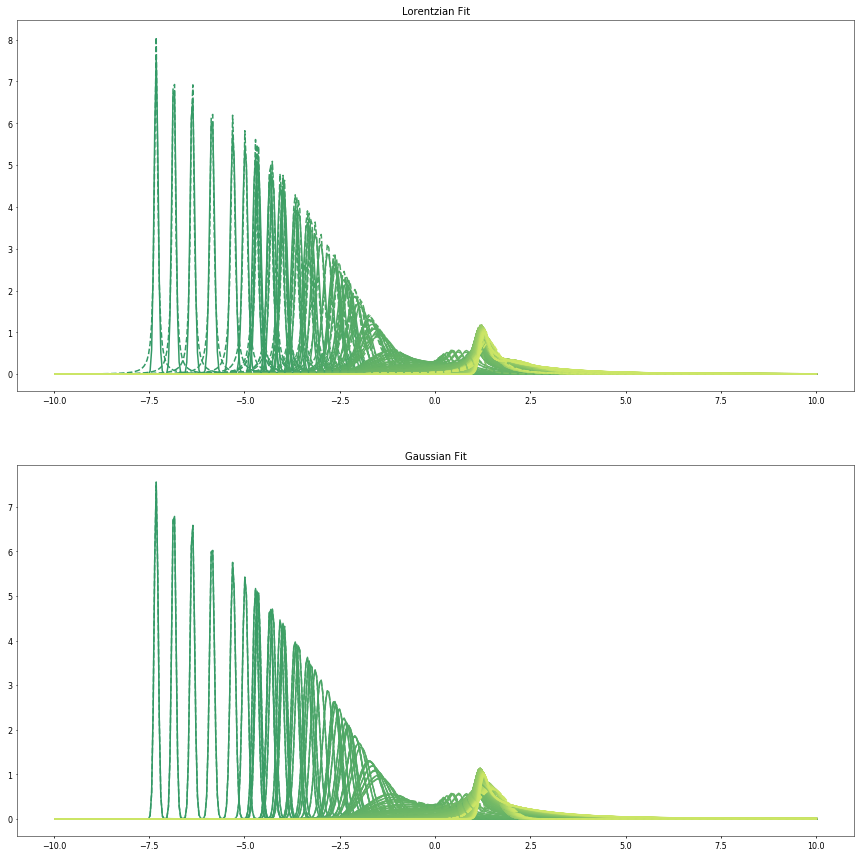

In [39]:
N=1.0/np.trapz(a, x=b[1:])

def _2Lorentzian(x, amp1, cen1, wid1, amp2,cen2,wid2):
    return (amp1*wid1**2/((x-cen1)**2+wid1**2)) +\
            (amp2*wid2**2/((x-cen2)**2+wid2**2))

def _2gaussian(x, amp1,cen1,sigma1, amp2,cen2,sigma2):
    return amp1*(1/(sigma1*(np.sqrt(2*np.pi))))*(np.exp(-((x-cen1)**2)/((2*sigma1)**2))) +\
           amp2*(1/(sigma2*(np.sqrt(2*np.pi))))*(np.exp(-((x-cen2)**2)/((2*sigma2)**2)))


def _1gaussian(x, amp1,cen1,sigma1):
    return amp1*(1/(sigma1*(np.sqrt(2*np.pi))))*(np.exp(-((x-cen1)**2)/((2*sigma1)**2))) 

plt.close("all")
fig01 = plt.figure(facecolor="1",figsize=(15,15))
axp = plt.subplot2grid((2,1), (0, 0))
axp1 = plt.subplot2grid((2,1), (1, 0))

jet= plt.get_cmap('summer')
colors = iter(jet(np.linspace(0.2,0.8,len(bl0_v))))

v_popt_2Lor=[]
v_popt_2Gauss=[]
for ii in range(len(bl0_v)):
    if I_app_vv[ii]<f2x(K_o):
        ini_conds=[max(al0_v[ii]), bl0_v[ii][np.argmax(al0_v[ii])], 0.5,0,2,0]
    if I_app_vv[ii]>f1x(K_o) and I_app_vv[ii]>f2x(K_o):
        if K_o>11.5:
            ini_conds=[max(al0_v[ii][bl0_v[ii]<0]),bl0_v[ii][bl0_v[ii]<0][np.argmax(al0_v[ii][bl0_v[ii]<0])],0.5,max(al0_v[ii][bl0_v[ii]>0]), bl0_v[ii][bl0_v[ii]>0][np.argmax(al0_v[ii][bl0_v[ii]>0])],0.1]
        else:
            iini_conds=[max(al0_v[ii][bl0_v[ii]<0]),bl0_v[ii][bl0_v[ii]<0][np.argmax(al0_v[ii][bl0_v[ii]<0])],0.5,max(al0_v[ii][bl0_v[ii]>0]), bl0_v[ii][bl0_v[ii]>0][np.argmax(al0_v[ii][bl0_v[ii]>0])],0.1]
            
    if K_o>11.5 and I_app_vv[ii]<f1x(K_o) and I_app_vv[ii]>f2x(K_o):
        ini_conds=[max(al0_v[ii][bl0_v[ii]<0]),bl0_v[ii][bl0_v[ii]<0][np.argmax(al0_v[ii][bl0_v[ii]<0])],0.5,max(al0_v[ii][bl0_v[ii]>0]), bl0_v[ii][bl0_v[ii]>0][np.argmax(al0_v[ii][bl0_v[ii]>0])],0.1]
    
    try:
        popt_2Lor, pcov_2Lor = scipy.optimize.curve_fit(_2Lorentzian, bl0_v[ii],al0_v[ii], p0=ini_conds)
    except:
        popt_2Lor=ini_conds
    
#     if I_app_vv[ii]<f2x(K_o):
#         ini_conds=[max(al0_v[ii]), bl0_v[ii][np.argmax(al0_v[ii])], 0.5,0,2,0.1]
#     if I_app_vv[ii]>f1x(K_o):
#         ini_conds=[0,-3,0.1,max(al0_v[ii][bl0_v[ii]>0]), bl0_v[ii][bl0_v[ii]>0][np.argmax(al0_v[ii][bl0_v[ii]>0])],0.1]
#     if I_app_vv[ii]<f1x(K_o) and I_app_vv[ii]>f2x(K_o):
#         ini_conds=[max(al0_v[ii][bl0_v[ii]<0]),bl0_v[ii][bl0_v[ii]<0][np.argmax(al0_v[ii][bl0_v[ii]<0])],0.5,max(al0_v[ii][bl0_v[ii]>0]), bl0_v[ii][bl0_v[ii]>0][np.argmax(al0_v[ii][bl0_v[ii]>0])],0.1]
#  popt_2Gauss, pcov_2Gauss = scipy.optimize.curve_fit(_2gaussian, bl0_v[ii]+corr,al0_v[ii], p0=ini_conds)
   
    if I_app_vv[ii]<f2x(K_o):
        ini_conds=[max(al0_v[ii]), bl0_v[ii][np.argmax(al0_v[ii])],0.5]
        popt_1Gauss, pcov_1Gauss = scipy.optimize.curve_fit(_1gaussian, bl0_v[ii],al0_v[ii], p0=ini_conds)
        popt_2Gauss=np.concatenate([popt_1Gauss,np.array([0,2,0.1])])
        pcov_2Gauss=pcov_1Gauss
    if I_app_vv[ii]>f1x(K_o):
        ini_conds=[max(al0_v[ii][bl0_v[ii]>0]), bl0_v[ii][bl0_v[ii]>0][np.argmax(al0_v[ii][bl0_v[ii]>0])],0.1]
        popt_1Gauss, pcov_1Gauss = scipy.optimize.curve_fit(_1gaussian, bl0_v[ii],al0_v[ii], p0=ini_conds)
        popt_2Gauss=np.concatenate([popt_1Gauss,np.array([0,-3,0.1])])        
    if I_app_vv[ii]<f1x(K_o) and I_app_vv[ii]>f2x(K_o):
        ini_conds=[max(al0_v[ii][bl0_v[ii]<0]),bl0_v[ii][bl0_v[ii]<0][np.argmax(al0_v[ii][bl0_v[ii]<0])],0.5,max(al0_v[ii][bl0_v[ii]>0]), bl0_v[ii][bl0_v[ii]>0][np.argmax(al0_v[ii][bl0_v[ii]>0])],0.05]
        popt_2Gauss, pcov_2Gauss = scipy.optimize.curve_fit(_2gaussian, bl0_v[ii],al0_v[ii], p0=ini_conds)
    
    v_popt_2Lor.append(popt_2Lor)
    v_popt_2Gauss.append(popt_2Gauss)
    colorii=next(colors)
    
    axp.plot(bl0_v[ii],al0_v[ii],color=colorii);axp.plot(bl0_v[ii],_2Lorentzian(bl0_v[ii],*popt_2Lor),'--',color=colorii)
    axp1.plot(bl0_v[ii],al0_v[ii],color=colorii);axp1.plot(bl0_v[ii],_2gaussian(bl0_v[ii],*popt_2Gauss),'--',color=colorii)
    
axp.set_title('Lorentzian Fit')
axp1.set_title('Gaussian Fit')

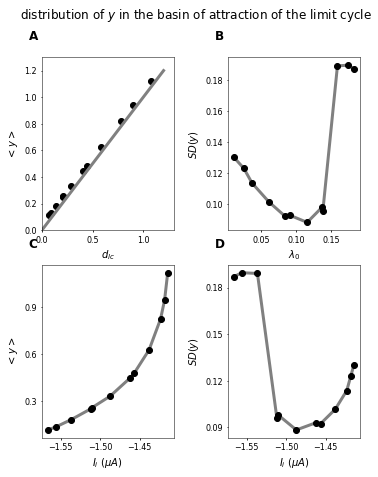

In [42]:
fig01 = plt.figure(facecolor="1",figsize=(fig_wide,fig_height*1.4))
ax0 = plt.subplot2grid((2,7), (0, 0), colspan=3,rowspan=1)
ax1 = plt.subplot2grid((2,7), (0, 4), colspan=3,rowspan=1)

ax2=plt.subplot2grid((2,7), (1, 0), colspan=3,rowspan=1)
ax3=plt.subplot2grid((2,7), (1, 4), colspan=3,rowspan=1)

ax1.plot([lam_0_v[ii] for ii in range(len(I_app_vv)) if (I_app_vv[ii]>f2x(K_o))*(I_app_vv[ii]<f1x(K_o))],[np.array(v_popt_2Gauss)[:,5][ii] for ii in range(len(I_app_vv)) if (I_app_vv[ii]>f2x(K_o))*(I_app_vv[ii]<f1x(K_o))],linewidth=3,color='grey')
ax1.plot([lam_0_v[ii] for ii in range(len(I_app_vv)) if (I_app_vv[ii]>f2x(K_o))*(I_app_vv[ii]<f1x(K_o))],[np.array(v_popt_2Gauss)[:,5][ii] for ii in range(len(I_app_vv)) if (I_app_vv[ii]>f2x(K_o))*(I_app_vv[ii]<f1x(K_o))],'o',color='k')
ax1.set_xlabel(r'$\lambda_0$')
ax1.set_ylabel(r'$SD(y)$')


ax0.plot([y_lc_v[ii] for ii in range(len(I_app_vv)) if (I_app_vv[ii]>f2x(K_o))*(I_app_vv[ii]<f1x(K_o))],[np.array(v_popt_2Gauss)[:,4][ii] for ii in range(len(I_app_vv)) if (I_app_vv[ii]>f2x(K_o))*(I_app_vv[ii]<f1x(K_o))],'o',color='k')
ax0.plot(np.linspace(0,1.2),np.linspace(0,1.2),linewidth=3,color='grey')
ax0.set_xlim(0,1.3)
ax0.set_ylim(0,1.3)
ax0.set_xlabel(r'$d_{lc}$')
ax0.set_ylabel(r'$<y> $')


ax3.plot([I_app_vv[ii] for ii in range(len(I_app_vv)) if (I_app_vv[ii]>f2x(K_o))*(I_app_vv[ii]<f1x(K_o))],[np.array(v_popt_2Gauss)[:,5][ii] for ii in range(len(I_app_vv)) if (I_app_vv[ii]>f2x(K_o))*(I_app_vv[ii]<f1x(K_o))],linewidth=3,color='grey')
ax3.plot([I_app_vv[ii] for ii in range(len(I_app_vv)) if (I_app_vv[ii]>f2x(K_o))*(I_app_vv[ii]<f1x(K_o))],[np.array(v_popt_2Gauss)[:,5][ii] for ii in range(len(I_app_vv)) if (I_app_vv[ii]>f2x(K_o))*(I_app_vv[ii]<f1x(K_o))],'o',color='k')
ax3.set_xlabel(r'$I_i$ $(\mu A)$')
ax3.set_ylabel(r'$SD(y)$')


ax2.plot([I_app_vv[ii] for ii in range(len(I_app_vv)) if (I_app_vv[ii]>f2x(K_o))*(I_app_vv[ii]<f1x(K_o))],[np.array(v_popt_2Gauss)[:,4][ii] for ii in range(len(I_app_vv)) if (I_app_vv[ii]>f2x(K_o))*(I_app_vv[ii]<f1x(K_o))],linewidth=3,color='grey')
ax2.plot([I_app_vv[ii] for ii in range(len(I_app_vv)) if (I_app_vv[ii]>f2x(K_o))*(I_app_vv[ii]<f1x(K_o))],[np.array(v_popt_2Gauss)[:,4][ii] for ii in range(len(I_app_vv)) if (I_app_vv[ii]>f2x(K_o))*(I_app_vv[ii]<f1x(K_o))],'o',color='k')
ax2.set_xlabel(r'$I_i$ $(\mu A)$')
ax2.set_ylabel(r'$<{y}>$')

locatory1 = MaxNLocator(nbins=4) # with 3 bins you will have 4 ticks
ax2.yaxis.set_major_locator(locatory1)
locatorx1 = MaxNLocator(nbins=4) # with 3 bins you will have 4 ticks
ax2.xaxis.set_major_locator(locatorx1)

locatory13 = MaxNLocator(nbins=4) # with 3 bins you will have 4 ticks
ax3.yaxis.set_major_locator(locatory13)
locatorx13 = MaxNLocator(nbins=4) # with 3 bins you will have 4 ticks
ax3.xaxis.set_major_locator(locatorx13)

########## Adding labels
ax=[ax0,ax1,ax2,ax3]
import string
for n, axs in enumerate(ax):   
    axs.text(-0.1, 1.1, string.ascii_uppercase[n], transform=axs.transAxes, 
            size=matplotlib.rcParams["font.size"], weight='bold')


iapp='I_app'
ko='K_o'
Koi_bifparx=float(dir_pars[ko][0][dir_pars[ko][0].index('(')+1:dir_pars[ko][0].index('*')])
if Koi_bifparx-int(Koi_bifparx)==0:
    stringi=ko+'_'+str(int(Koi_bifparx))+'_'
else:
    Koi_bifparx_aux=int((Koi_bifparx-int(Koi_bifparx))*100)
    stringi=ko+'_'+str(int(Koi_bifparx))+'_'+str(Koi_bifparx_aux)+'_'

stringi=stringi+iapp+'_'+str(int(float(dir_pars[iapp][0][0:dir_pars[iapp][0].index('*')])*10))
stringi=stringi+'ge_'+str(int(ge_amp*100))+'_gi_'+str(int(gi_amp*100))
fig01.suptitle('distribution of $y$ in the basin of attraction of the limit cycle')

name_file='Parametrizing_Mu_sigma_lc_'+str(num_neurons)+'_num_runs_'+str(1)+'_lengthSim_'+str(int(time_stim))+'_'
name_i=name_file+stringi

fig_file_title='fig_'+name_i
md_dir={
        'Title':'parametrizing distributions of y relative to the phase portraits',
        'Author':"Susana Contreras 25/02/2019",
        'Subject':'Network simulation '+str(num_neurons)+' neurons snapshot with Ko='+str(int(float(bifparx[ko][0][bifparx[ko][0].index('(')+1:bifparx[ko][0].index('*')])))+' '+iapp+'='+dir_pars[iapp][0][0:dir_pars[iapp][0].index('*')]+' C_E='+str(np.mean(v_in_degree_E))+' C_I='+str(np.mean(v_in_degree_I)),
        'Keywords':"Ko bistability, network synchronization, SNIC, SNL,concentration dynamics, spiking statistics"
        }

# saving_pdf_figure(fig01,'./Figs/'+fig_file_title,md_dir)

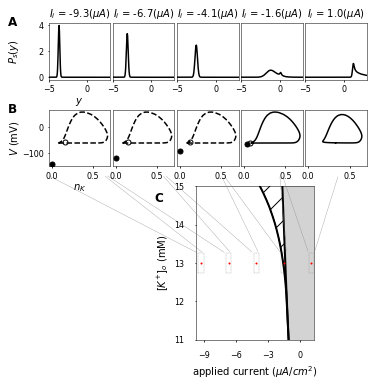

In [44]:
sigma_v=[1,0,0,0]
plt.close("all")

iargis_iapis=[np.argmin(np.abs(iiapi-I_app_vv)) for iiapi in v_iapp]

# n_splts=len(v_iapp)

fig01 = plt.figure(facecolor="1",figsize=(fig_wide,fig_height*1.2))
axpl = plt.subplot2grid((68,4*n_splts), (34, int(4*(n_splts-1)-int(3*n_splts/2))), colspan=int(3*n_splts/2),rowspan=32)

ax11=[]
for ii_iapi in range(len(v_iapp[::int(len(v_iapp)/n_splts)][:-1])):
    if ii_iapi>0:
        ax11.append(plt.subplot2grid((68,4*(n_splts-1)), (0, ii_iapi*4), colspan=4,rowspan=12,sharex=ax11[0],sharey=ax11[0]))
    else:
        ax11.append(plt.subplot2grid((68,4*(n_splts-1)), (0, ii_iapi*4), colspan=4,rowspan=12))

ax=[]
for ii_iapi in range(len(v_iapp[::int(len(v_iapp)/n_splts)][:-1])):
    if ii_iapi>0:
        ax.append(plt.subplot2grid((68,4*(n_splts-1)), (18, ii_iapi*4), colspan=4,rowspan=12,sharex=ax[0],sharey=ax[0]))
    else:
        ax.append(plt.subplot2grid((68,4*(n_splts-1)), (18, ii_iapi*4), colspan=4,rowspan=12))

axpl.set_xlim([min(v_iapp)-0.5,max(v_iapp)+0.2])
axpl.set_ylim([K_o-2.0,15])

s_x=1;s_y=0
##### plot sn disappearance, hopf and limit cycle onset
axpl.plot(m_res_par_sn_KoIapp[s_x],m_res_par_sn_KoIapp[s_y],linewidth=2,color=[0,0,0])
axpl.plot(m_res_par_lc_KoIapp[s_x],m_res_par_lc_KoIapp[s_y],linewidth=2,color=[0,0,0])
axpl.plot(m_res_par_HF0[s_x],m_res_par_HF0[s_y],'--',linewidth=2,color=[0,0,0])

##### Drawing the different regions
a=m_res_par_lc_KoIapp[s_x]
b=m_res_par_sn_KoIapp[s_y]
bx=m_res_par_sn_KoIapp[s_x]
c=m_res_par_HF0[s_x]
cy=m_res_par_HF0[s_y]
f1x = interp1d(m_res_par_sn_KoIapp[s_y][bx.argsort()],bx[bx.argsort()],fill_value=min(m_res_par_sn_KoIapp[s_x]), bounds_error=False)
f2x = interp1d(m_res_par_lc_KoIapp[s_y][a.argsort()],a[a.argsort()],fill_value=min(m_res_par_lc_KoIapp[s_x]), bounds_error=False)
f3x = interp1d(m_res_par_HF0[s_y][c.argsort()],c[c.argsort()],fill_value=min(m_res_par_lc_KoIapp[s_x]), bounds_error=False)
yy=m_res_par_sn_KoIapp[s_x][b.argsort()]
yy2=np.minimum(f3x(b[b.argsort()]),yy)
axpl.fill_betweenx(b[b.argsort()],f2x(b[b.argsort()]),yy2,facecolor="none",hatch="/",lw=1., edgecolor='k')
cc=[i for i in b.argsort() if f3x(b[i])>f1x(b[i])]
axpl.fill_betweenx(b[cc],f1x(b[cc]),f3x(b[cc]),color='lightgray')
##### Plot axes
axpl.set_ylabel('$[K^{+}]_o$ (mM)')
axpl.set_xlabel('applied current $(\mu A/cm^2)$')
axpl.tick_params(axis='y', pad=10)
axpl.tick_params(axis='x', pad=10)

jet= plt.get_cmap('summer')
colors = iter(jet(np.linspace(0.2,0.8,len(v_iapp[::int(len(v_iapp)/n_splts)][:-1]))))

axpl.set_xlim([min(v_iapp[::int(len(v_iapp)/n_splts)][1:])-0.5,max(v_iapp[::int(len(v_iapp)/n_splts)][1:])+0.2])
###### Phase planes
for ii_iapi,I_iapi in enumerate(v_iapp[::int(len(v_iapp)/n_splts)][1:]):

    ### Plot limit cycle onset
    l0i,ys_0i,saddle,stable,limit_cycle=fl0ys0i_sn_st_lc(I_iapi)
    ax11[ii_iapi].set_title("$I_i$ = "+ "{:.1f}".format(I_iapi)+'$(\mu A)$')
#     for ii_api_lc in range(len(v_I_app)):
    try:
        ax[ii_iapi].plot(limit_cycle[1],limit_cycle[0],color='black')
    except:
        try:
            for ii_limi in v_LC0i[::-1]:
                if len(ii_limi)>0:
                    limit_cycle_g=ii_limi
          
            ax[ii_iapi].plot(limit_cycle_g[1],limit_cycle_g[0],'--',color='black')
        except:
            pass
        pass

    try:
        ax[ii_iapi].plot(saddle[1],saddle[0],'o',markersize=5,mfc='none',color='black')
    except:
        pass

    try:
        ax[ii_iapi].plot(stable[1],stable[0],'o',markersize=5,color='black')
    except:
        pass

#     ax[ii_iapi].set_ylabel('$'+v_one_sim_s[ii_iapi][0]+'$')
#     ax[ii_iapi].set_xlabel('$'+v_one_sim_s[ii_iapi][1]+'$')
    axpl.plot(v_iapp[np.argmin(abs(I_iapi-v_iapp))],K_o,'o',markersize=1,color='r')
    zoomingBox_4PhasePlane(axpl, np.array([v_iapp[np.argmin(abs(I_iapi-v_iapp))]-0.25,v_iapp[np.argmin(abs(I_iapi-v_iapp))]+0.25,K_o-0.25,K_o+0.25]), ax[ii_iapi],color='grey',linewidth=matplotlib.rcParams['lines.linewidth']*0.2)
    ax11[ii_iapi].plot(bl0_v[iargis_iapis[np.argmin(abs(I_iapi-v_iapp))]],al0_v[iargis_iapis[np.argmin(abs(I_iapi-v_iapp))]],color='black')
    if ii_iapi>0:
        ax11[ii_iapi].get_yaxis().set_visible(False)
        ax[ii_iapi].get_yaxis().set_visible(False)
        
    colorii=next(colors)
#     sns.kdeplot(bl0_v[iargis_iapis[ii_iapi]],al0_v[iargis_iapis[ii_iapi]], shade=True,ax=ax11[ii_iapi],color=colorii)
    
    
    try:
        ax11.plot(np.ones(10)*(np.dot(l0i,stable)-ys_0i),np.linspace(0,5,10),'--',color='black')
    except:
        pass
            
    ax11[ii_iapi].set_xlim([-5,3])
    



    
ax11[0].set_ylabel(r'$P_s(y)$')
ax11[0].set_xlabel(r'$y$',labelpad=2)
ax[0].set_ylabel(r'$V$ (mV)')
ax[0].set_xlabel(r'$n_K$',labelpad=2)
############################################
###### Fixing the number of ticks
locatorypl = MaxNLocator(nbins=4) # with 3 bins you will have 4 ticks
axpl.yaxis.set_major_locator(locatorypl)
############################################


locatorxpl = MaxNLocator(nbins=4) # with 3 bins you will have 4 ticks
axpl.xaxis.set_major_locator(locatorxpl)
############################################
### Aligning y labels
############################################
labely = -0.45  # axes coords
ax[0].yaxis.set_label_coords(labely, 0.5)
ax11[0].yaxis.set_label_coords(labely, 0.5)

############################################
### Adding labels
############################################

import string
for n, axs in enumerate([ax11[0],ax[0],axpl]):
    if n==2:
        axs.text(-0.35, 0.9, string.ascii_uppercase[n], transform=axs.transAxes, 
            size=matplotlib.rcParams["font.size"], weight='bold')
    else:
        axs.text(-0.67, 0.95, string.ascii_uppercase[n], transform=axs.transAxes, 
            size=matplotlib.rcParams["font.size"], weight='bold')



iapp='I_app'
ko='K_o'
Koi_bifparx=float(dir_pars[ko][0][dir_pars[ko][0].index('(')+1:dir_pars[ko][0].index('*')])
if Koi_bifparx-int(Koi_bifparx)==0:
    stringi=ko+'_'+str(int(Koi_bifparx))+'_'
else:
    Koi_bifparx_aux=int((Koi_bifparx-int(Koi_bifparx))*100)
    stringi=ko+'_'+str(int(Koi_bifparx))+'_'+str(Koi_bifparx_aux)+'_'
stringi=stringi+iapp+'_'+str(int(float(dir_pars[iapp][0][0:dir_pars[iapp][0].index('*')])*10))
stringi=stringi+'ge_'+str(int(ge_amp*100))+'_gi_'+str(int(gi_amp*100))


name_file='HistY_and_Phase_diagrams_neuroni_'+str(num_neurons)+'_num_runs_'+str(1)+'_lengthSim_'+str(int(time_stim))+'_'
name_i=name_file+stringi

fig_file_title='fig_'+name_i
md_dir={
        'Title':'histogram y and phase diagrams relative 2 bistable region',
        'Author':"Susana Contreras 25/02/2019",
        'Subject':'Network simulation '+str(num_neurons)+' neurons snapshot with Ko='+str(int(float(bifparx[ko][0][bifparx[ko][0].index('(')+1:bifparx[ko][0].index('*')])))+' '+iapp+'='+dir_pars[iapp][0][0:dir_pars[iapp][0].index('*')]+' C_E='+str(np.mean(v_in_degree_E))+' C_I='+str(np.mean(v_in_degree_I)),
        'Keywords':"Ko bistability, network synchronization, SNIC, SNL,concentration dynamics, spiking statistics"
        }

# locatory1 = MaxNLocator(nbins=4) # with 3 bins you will have 4 ticks
# ax.yaxis.set_major_locator(locatory1)

# saving_pdf_figure(fig01,dir_figs+fig_file_title,md_dir)    
# saving_pdf_figure(fig01,'./Figs/'+fig_file_title,md_dir)

In [45]:
import matplotlib.pyplot as plt
from scipy import interpolate

# zamp1G_iapp = np.polyfit(np.array(I_app_vv)[f1x(K_o)>I_app_vv],np.array(v_popt_2Gauss)[:,0][f1x(K_o)>I_app_vv], 4)
# famp1G_iapp=np.poly1d(zamp1G_iapp)
famp1G_iapp = interpolate.interp1d(np.array(I_app_vv),np.array(v_popt_2Gauss)[:,0])

# zcen1G_iapp = np.polyfit(np.array(I_app_vv)[f1x(K_o)>I_app_vv],np.array(v_popt_2Gauss)[:,1][f1x(K_o)>I_app_vv], 1)
# fcen1G_iapp=np.poly1d(zcen1G_iapp)
fcen1G_iapp=interpolate.interp1d(np.array(I_app_vv),np.array(v_popt_2Gauss)[:,1])


# zwid1G_iapp = np.polyfit(np.array(I_app_vv)[f1x(K_o)>I_app_vv],np.array(v_popt_2Gauss)[:,2][f1x(K_o)>I_app_vv], 5)
# fwid1G_iapp=np.poly1d(zwid1G_iapp)
fwid1G_iapp=interpolate.interp1d(np.array(I_app_vv),np.array(v_popt_2Gauss)[:,2])


# zamp2G_iapp = np.polyfit(np.array(I_app_vv)[f2x(K_o)<I_app_vv],np.array(v_popt_2Gauss)[:,3][f2x(K_o)<I_app_vv], 2)
# famp2G_iapp=np.poly1d(zamp2G_iapp)
famp2G_iapp=interpolate.interp1d(np.array(I_app_vv),np.array(v_popt_2Gauss)[:,3])


# zcen2G_iapp = np.polyfit(np.array(I_app_vv)[f2x(K_o)<I_app_vv],np.array(v_popt_2Gauss)[:,4][f2x(K_o)<I_app_vv], 2)
# fcen2G_iapp=np.poly1d(zcen2G_iapp)
fcen2G_iapp=interpolate.interp1d(np.array(I_app_vv),np.array(v_popt_2Gauss)[:,4])


# zwid2G_iapp = np.polyfit(np.array(I_app_vv)[f2x(K_o)<I_app_vv],np.array(v_popt_2Gauss)[:,5][f2x(K_o)<I_app_vv], 2)
# fwid2G_iapp=np.poly1d(zwid2G_iapp)
fwid2G_iapp=interpolate.interp1d(np.array(I_app_vv),np.array(v_popt_2Gauss)[:,5])


def pot_deGauss(Iapi,n):
#     bii=np.linspace(-5,5,n)
    bii=np.linspace(min(bl0_v[0]),max(bl0_v[0]),n)
    aii=_2gaussian(bii, max(famp1G_iapp(Iapi),0), fcen1G_iapp(Iapi), max(fwid1G_iapp(Iapi),0.1), max(famp2G_iapp(Iapi),0), fcen2G_iapp(Iapi), max(fwid2G_iapp(Iapi),0.1))
    N=1.0/np.trapz(aii, x=bii)
    Uy=(-np.log(aii/N)*2*sig_proj**2)
    return Uy

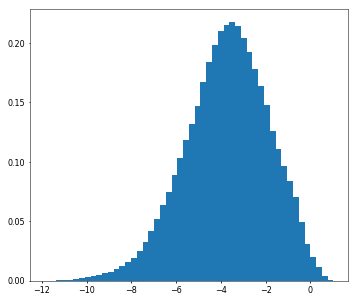

In [46]:
## Assuming stationarity...
## refined distribution..


aw_pos_ref,bw_pos_ref,cw_pos_ref=plt.hist(x_inp[i_unit],bins=10*nbins,label='$ < input > $'+str(x_mean_inp[i_unit]),density=True)## here a will give the weighting for each state, or the proportion of times when the unit was there, and b will give the actual currents


In [47]:
np.trapz(aw_pos_ref,x=bw_pos_ref[1:])

0.9998945

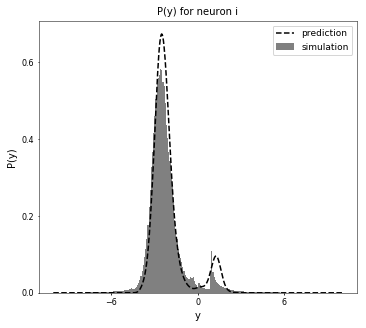

<Figure size 410.4x360 with 0 Axes>

In [48]:

fig01 = plt.figure(facecolor="1",figsize=(fig_wide,fig_height))

axp = plt.subplot2grid((1,1), (0, 0))
size_legend_font=size_axis_font
a,b,c=axp.hist(a_y[i_unit],bins=bl0_v[0][::2],density=True, color='grey', rasterized=True, label='simulation')
# axp.set_xlim([-10,4])
xxi=bw_pos_ref[1:]
n=500

s_aii=np.zeros(n)
bii=np.linspace(min(bl0_v[0]),max(bl0_v[0]),n)
for ii,Iapi in enumerate(xxi):
    if Iapi>min(I_app_vv) and Iapi<max(I_app_vv):
        aii=_2gaussian(bii, max(famp1G_iapp(Iapi),0), fcen1G_iapp(Iapi), max(fwid1G_iapp(Iapi),0.1), max(famp2G_iapp(Iapi),0), fcen2G_iapp(Iapi), max(fwid2G_iapp(Iapi),0.1))
        s_aii=s_aii+aw_pos_ref[ii]*aii
 
N=1.0/np.trapz(s_aii, x=bii)
axp.plot(bii,N*s_aii,'--',color='black',label='prediction')
axp.set_title('P(y) for neuron i')
axp.set_xlabel('y')
axp.set_ylabel('P(y)')
axp.legend()

locatory1 = MaxNLocator(nbins=4) # with 3 bins you will have 4 ticks
axp.yaxis.set_major_locator(locatory1)

locatorx1 = MaxNLocator(nbins=4) # with 3 bins you will have 4 ticks
axp.xaxis.set_major_locator(locatorx1)



name_file='Disty_neuroni_'+str(num_neurons)+'_num_runs_'+str(1)+'_lengthSim_'+str(int(time_stim))+'_'
name_i=name_file+stringi

fig_file_title='fig_'+name_i
md_dir={
        'Title':'Distribution of y of neuron i',
        'Author':"Susana Contreras 25/02/2019",
        'Subject':'Network simulation '+str(num_neurons)+' neurons snapshot with Ko='+bifparx[ko][0][bifparx[ko][0].index('(')+1:bifparx[ko][0].index('*')]+' '+'I_app'+'='+dir_pars['I_app'][0][0:dir_pars['I_app'][0].index('*')]+' C_E='+str(np.mean(v_in_degree_E))+' C_I='+str(np.mean(v_in_degree_I)),
        'Keywords':"Ko bistability, network synchronization, SNIC, SNL"
        }

saving_pdf_figure(fig01,dir_figs+fig_file_title,md_dir)

i_unit=np.array(range(len(x_mean_inp)))[np.argmin(np.abs(x_mean_inp-np.median(x_mean_inp)))]
# saving_pdf_figure(fig01,'./Figs/'+fig_file_title,md_dir)

WARNING    /home/contreras/anaconda2/envs/AUTO_py37/lib/python3.7/site-packages/matplotlib/axes/_axes.py:6521: MatplotlibDeprecationWarning: 
The 'normed' kwarg was deprecated in Matplotlib 2.1 and will be removed in 3.1. Use 'density' instead.
  alternative="'density'", removal="3.1")
 [py.warnings]


Mean distribution
-5.171149237567823
1.0
0.99637775
Mean distribution
-2.5614506779138075
0.99818


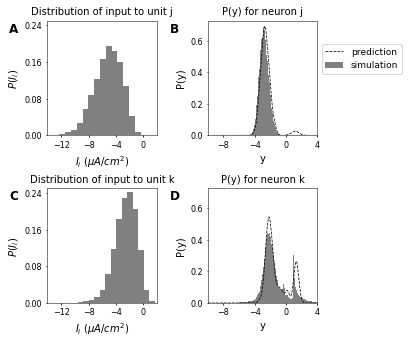

In [49]:
fig01 = plt.figure(facecolor="1",figsize=(fig_wide,fig_height*1.1))

sx=7
sy=7
axp0 = plt.subplot2grid((18,20), (0, 0),colspan=sx,rowspan=sy)
axp = plt.subplot2grid((18,20), (0, 10),colspan=sx,rowspan=sy)
axp02 = plt.subplot2grid((18,20), (10, 0),colspan=sx,rowspan=sy,sharex=axp0,sharey=axp0)
axp2 = plt.subplot2grid((18,20), (10, 10),colspan=sx,rowspan=sy,sharex=axp,sharey=axp)

########################################
#### Neuron with low input ##########
########################################
i_unit_min=np.array(range(len(x_mean_inp)))[np.argmin(np.abs(x_mean_inp-np.min(x_mean_inp)))]

print('Mean distribution')
print(x_mean_inp[i_unit_min])

a,b,c=axp.hist(a_y[i_unit_min],bins=bl0_v[0][::2],normed=True, color='grey', rasterized=True, label='simulation')
axp.set_xlim([-10,4])
print(np.trapz(a,x=b[1:]))
aw_pos_ref,bw_pos_ref,cw_pos=axp0.hist(x_inp[i_unit_min],bins=3*nbins,label='$ < input > $'+str(x_mean_inp[i_unit_min]),density=True, color='grey',rasterized=True)## here a will give the weighting for each state, or the proportion of times when the unit was there, and b will give the actual currents
axp0.set_xlabel(r'$I_i$ $(\mu A / cm^2)$')
axp0.set_ylabel(r'$P(I_i)$ ')
axp0.set_title('Distribution of input to unit j')
axp0.set_xlim([-14,2])
axp0.set_ylim([0,0.25])
print(np.trapz(aw_pos_ref,x=bw_pos_ref[1:]))


xxi=bw_pos_ref[1:]
n=500

s_aii=np.zeros(n)
bii=np.linspace(min(bl0_v[0]),max(bl0_v[0]),n)
for ii,Iapi in enumerate(xxi):
    if Iapi>min(I_app_vv) and Iapi<max(I_app_vv):
        aii=_2gaussian(bii, max(famp1G_iapp(Iapi),0), fcen1G_iapp(Iapi), max(fwid1G_iapp(Iapi),0.1), max(famp2G_iapp(Iapi),0), fcen2G_iapp(Iapi), max(fwid2G_iapp(Iapi),0.1))
        s_aii=s_aii+aw_pos_ref[ii]*aii
 
N=1.0/np.trapz(s_aii, x=bii)
axp.plot(bii,N*s_aii,'--',color='black',linewidth=matplotlib.rcParams['lines.linewidth']*0.5,label='prediction')
axp.set_title('P(y) for neuron j')
axp.set_xlabel('y')
axp.set_ylabel('P(y)')
axp.legend(loc=3, bbox_to_anchor=(1, 0.5))
########################################
#### Neuron with high input ##########
########################################
i_unit_max=np.array(range(len(x_mean_inp)))[np.argmin(np.abs(x_mean_inp-np.sort(x_mean_inp)[-5]))]

print('Mean distribution')
print(x_mean_inp[i_unit_max])

a,b,c=axp2.hist(a_y[i_unit_max],bins=bl0_v[0][::2],normed=True, color='grey', rasterized=True, label='simulation')
axp2.set_xlim([-10,4])

aw_pos_ref,bw_pos_ref,cw_pos=axp02.hist(x_inp[i_unit_max],bins=3*nbins,label='$ < input > $'+str(x_mean_inp[i_unit_max]),density=True, color='grey',rasterized=True)## here a will give the weighting for each state, or the proportion of times when the unit was there, and b will give the actual currents
print(np.trapz(aw_pos_ref,x=bw_pos_ref[1:]))

axp02.set_xlabel(r'$I_i$ $(\mu A / cm^2)$')
axp02.set_ylabel(r'$P(I_i)$ ')
axp02.set_title('Distribution of input to unit k')
axp02.set_xlim([-14,2])
axp02.set_ylim([0,0.25])
xxi=bw_pos_ref[1:]
n=500

s_aii=np.zeros(n)
bii=np.linspace(min(bl0_v[0]),max(bl0_v[0]),n)
for ii,Iapi in enumerate(xxi):
    if Iapi>min(I_app_vv) and Iapi<max(I_app_vv):
        aii=_2gaussian(bii, max(famp1G_iapp(Iapi),0), fcen1G_iapp(Iapi), max(fwid1G_iapp(Iapi),0.1), max(famp2G_iapp(Iapi),0), fcen2G_iapp(Iapi), max(fwid2G_iapp(Iapi),0.1))
        s_aii=s_aii+aw_pos_ref[ii]*aii
 
N=1.0/np.trapz(s_aii, x=bii)
axp2.plot(bii,N*s_aii,'--',color='black',linewidth=matplotlib.rcParams['lines.linewidth']*0.5,label='prediction')
axp2.set_title('P(y) for neuron k')
axp2.set_xlabel('y')
axp2.set_ylabel('P(y)')
# axp2.legend()

########################################
#### Fixing number of ticks ##########
########################################
locatory1 = MaxNLocator(nbins=4) # with 3 bins you will have 4 ticks
axp.yaxis.set_major_locator(locatory1)
locatorx1 = MaxNLocator(nbins=4) # with 3 bins you will have 4 ticks
axp.xaxis.set_major_locator(locatorx1)
########################################
locatory10 = MaxNLocator(nbins=4) # with 3 bins you will have 4 ticks
axp0.yaxis.set_major_locator(locatory10)
locatorx10 = MaxNLocator(nbins=4) # with 3 bins you will have 4 ticks
axp0.xaxis.set_major_locator(locatorx10)
########################################
locatory12 = MaxNLocator(nbins=4) # with 3 bins you will have 4 ticks
axp2.yaxis.set_major_locator(locatory12)
locatorx12 = MaxNLocator(nbins=4) # with 3 bins you will have 4 ticks
axp2.xaxis.set_major_locator(locatorx12)
########################################
locatory102 = MaxNLocator(nbins=4) # with 3 bins you will have 4 ticks
axp02.yaxis.set_major_locator(locatory102)
locatorx102 = MaxNLocator(nbins=4) # with 3 bins you will have 4 ticks
axp02.xaxis.set_major_locator(locatorx102)

import string
for n, axs in enumerate([axp0,axp,axp02,axp2]):
    axs.text(-0.35, 0.9, string.ascii_uppercase[n], transform=axs.transAxes, 
        size=matplotlib.rcParams["font.size"], weight='bold')




name_file='Disty_neuronjk_min_max_'+str(num_neurons)+'_num_runs_'+str(1)+'_lengthSim_'+str(int(time_stim))+'_'
name_i=name_file+stringi

fig_file_title='fig_'+name_i
md_dir={
        'Title':'Distribution of y of neuron i',
        'Author':"Susana Contreras 25/02/2019",
        'Subject':'Network simulation '+str(num_neurons)+' neurons snapshot with Ko='+bifparx[ko][0][bifparx[ko][0].index('(')+1:bifparx[ko][0].index('*')]+' '+'I_app'+'='+dir_pars['I_app'][0][0:dir_pars['I_app'][0].index('*')]+' C_E='+str(np.mean(v_in_degree_E))+' C_I='+str(np.mean(v_in_degree_I)),
        'Keywords':"Ko bistability, network synchronization, SNIC, SNL"
        }

# saving_pdf_figure(fig01,dir_figs+fig_file_title,md_dir)

# saving_pdf_figure(fig01,'./Figs/'+fig_file_title,md_dir)

In [51]:
v_in_degree_E=[]
v_in_degree_I=[]
v_out_degree_E=[]
v_out_degree_I=[]
for ii in np.unique(dir_i[0]['J']['J_e'][1]):
    v_in_degree_E.append(sum(np.array(dir_i[0]['J']['J_e'][1])==ii))
    v_in_degree_I.append(sum(np.array(dir_i[0]['J']['J_i'][1])==ii))
    v_out_degree_E.append(sum(np.array(dir_i[0]['J']['J_e'][0])==ii))
    v_out_degree_I.append(sum(np.array(dir_i[0]['J']['J_i'][0])==ii))

In [52]:
### compare to self consistent theory by Amit and Brunel 1997
tau_m=10
tau_E=5
tau_I=10
v_0=np.mean(dir_i[0]['Population_Rate']['Freq_Pop'])/1000.0## Rate in ms
v_E=np.mean(dir_i[0]['Population_Rate']['Exc_Pop'])/1000.0## Rate in ms
v_I=np.mean(dir_i[0]['Population_Rate']['Inh_Pop'])/1000.0## Rate in ms


K=np.mean(np.concatenate([np.array(v_in_degree_I),np.array(v_in_degree_E)]))
delta_std_K=np.std(np.concatenate([np.array(v_in_degree_I),np.array(v_in_degree_E)]))
J_e=0.035*2#ms...multiplied by conductance..
J_i=0.27*2#ms...multiplied by conductance..
#### Replacing Je, and J_I by the integral of the synaptic kernel
intJ_e=J_e*(-tau_E*np.exp(-100/tau_E)+tau_E*np.exp(0))/tau_E
intJ_I=J_i*(-tau_I*np.exp(-100/tau_I)+tau_I*np.exp(0))/tau_I


## Input distribution from Brunel 2000
mu_input_theor=tau_E*v_E*K*intJ_e-tau_I*v_I*K*intJ_I+iapi
sigma_input_theor=intJ_e**2*K*v_E*tau_E+intJ_I**2*K*v_I*tau_I

bw_pos_pop_theor=np.linspace(-20,10,200)
Dist_theor=_2gaussian(bw_pos_pop_theor, 1.0,mu_input_theor,np.sqrt(sigma_input_theor), 0,1,1)
Dist_theor=Dist_theor/np.trapz(Dist_theor,x=bw_pos_pop_theor)



In [53]:
np.trapz(Dist_theor,x=bw_pos_pop_theor)

1.0

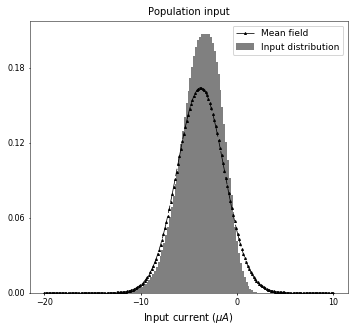

<Figure size 410.4x360 with 0 Axes>

In [59]:
f20, ax= plt.subplots(1,facecolor="1",figsize=(fig_wide,fig_height))

ax.bar(bw_pos_pop[1:],aw_pos_pop,color='grey',label='Input distribution')
line=ax.plot(bw_pos_pop_theor,Dist_theor,dashes=[30, 5, 10, 5],marker='^',markersize=2,linewidth=matplotlib.rcParams['lines.linewidth']*0.5,color='black',label='Mean field')

ax.set_xlabel('Input current $(\mu A)$')
ax.set_title('Population input')
ax.legend(loc='best')

locatory1 = MaxNLocator(nbins=4) # with 3 bins you will have 4 ticks
ax.yaxis.set_major_locator(locatory1)
locatorx1 = MaxNLocator(nbins=4) # with 3 bins you will have 4 ticks
ax.xaxis.set_major_locator(locatorx1)

name_file='DistInput_population_'+str(num_neurons)+'_num_runs_'+str(1)+'_lengthSim_'+str(int(time_stim))+'_'
name_i=name_file+stringi

fig_file_title='fig_'+name_i
md_dir={
        'Title':'Distribution of input to population',
        'Author':"Susana Contreras 25/02/2019",
        'Subject':'Network simulation '+str(num_neurons)+' neurons snapshot with Ko='+bifparx[ko][0][bifparx[ko][0].index('(')+1:bifparx[ko][0].index('*')]+' '+'I_app'+'='+dir_pars['I_app'][0][0:dir_pars['I_app'][0].index('*')]+' C_E='+str(np.mean(v_in_degree_E))+' C_I='+str(np.mean(v_in_degree_I)),
        'Keywords':"Ko bistability, network synchronization, SNIC, SNL"
        }


saving_pdf_figure(f20,'./Figs/'+fig_file_title,md_dir)

In [55]:
'I_app'+'='+dir_pars['I_app'][0][0:dir_pars['I_app'][0].index('*')]

'I_app=1.31921738'

In [56]:
from random import choices
population = bw_pos_pop[1:]
weights =aw_pos_pop
v_samp=choices(population, weights, k=100000)
print('real mu='+str(mean(v_samp)))
print('real sigma='+str(np.var(v_samp)))

real mu=-3.7053174491146432
real sigma=3.7663878634691152


In [57]:
print('mean field mu='+str(mu_input_theor))
print('mean field sigma='+str(sigma_input_theor))

mean field mu=-3.783736548363143
mean field sigma=2.9618125801894077


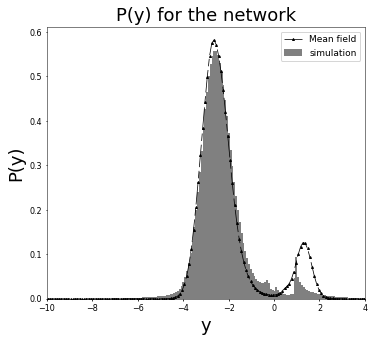

In [58]:
# f20, ax= plt.subplots(1,facecolor="1",figsize=(8,6))
f20, ax= plt.subplots(1,facecolor="1",figsize=(fig_wide,fig_height))

a,b,c=ax.hist(np.concatenate(a_y),bins=bl0_v[0][::2],density=True, color='grey', rasterized=True,label='simulation')
plt.xlim([-5,5])

xxi=bw_pos_pop_theor
n=len(xxi)

s_aii=np.zeros(n)
s_aii2=np.zeros(n)
bii=np.linspace(min(bl0_v[0]),max(bl0_v[0]),n)
for ii,Iapi in enumerate(xxi):
    if Iapi>min(I_app_vv) and Iapi<max(I_app_vv):
        aii=_2gaussian(bii, max(famp1G_iapp(Iapi),0), fcen1G_iapp(Iapi), max(fwid1G_iapp(Iapi),0.1), max(famp2G_iapp(Iapi),0), fcen2G_iapp(Iapi), max(fwid2G_iapp(Iapi),0.1))
#         s_aii2=s_aii2+aw_pos_pop[ii]*aii
        s_aii=s_aii+Dist_theor[ii]*aii
 
N=1.0/np.trapz(s_aii, x=bii)
ax.plot(bii,N*s_aii,'--',dashes=[30, 5, 10, 5],marker='^',markersize=2,linewidth=matplotlib.rcParams['lines.linewidth']*0.5,color='black',label='Mean field')
# ax.plot(bii,N*s_aii2,'--',color='black',label='prediction')
ax.set_title('P(y) for the network',fontsize=size_axis_font)
ax.set_xlabel('y',fontsize=size_axis_font)
ax.set_ylabel('P(y)',fontsize=size_axis_font)

ax.legend()
ax.set_xlim([-10,4])


locatory1 = MaxNLocator(nbins=4) # with 3 bins you will have 4 ticks
axp.yaxis.set_major_locator(locatory1)
locatorx1 = MaxNLocator(nbins=4) # with 3 bins you will have 4 ticks
axp.xaxis.set_major_locator(locatorx1)

name_file='Disty_population_'+str(num_neurons)+'_num_runs_'+str(1)+'_lengthSim_'+str(int(time_stim))+'_'
name_i=name_file+stringi

fig_file_title='fig_'+name_i
md_dir={
        'Title':'Distribution of y of population',
        'Author':"Susana Contreras 25/02/2019",
'Subject':'Network simulation '+str(num_neurons)+' neurons snapshot with Ko='+bifparx[ko][0][bifparx[ko][0].index('(')+1:bifparx[ko][0].index('*')]+' '+'I_app'+'='+dir_pars['I_app'][0][0:dir_pars['I_app'][0].index('*')]+' C_E='+str(np.mean(v_in_degree_E))+' C_I='+str(np.mean(v_in_degree_I)),
        'Keywords':"Ko bistability, network synchronization, SNIC, SNL"
        }

# saving_pdf_figure(f20,dir_figs+fig_file_title,md_dir)
# saving_pdf_figure(f20,'./Figs/'+fig_file_title,md_dir)

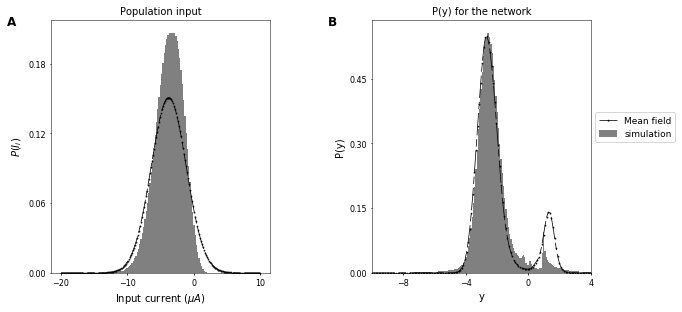

<Figure size 410.4x360 with 0 Axes>

In [105]:
# f20, ax= plt.subplots(1,facecolor="1",figsize=(8,6))
f20 = plt.figure(facecolor="1",figsize=(2*fig_wide,2*fig_height*0.6))

sx=7
sy=7
ax = plt.subplot2grid((9,20), (0, 0),colspan=sx,rowspan=sy)
ax1 = plt.subplot2grid((9,20), (0, 10),colspan=sx,rowspan=sy)


#################################3333
####### Input distribution
#################################
ax.bar(bw_pos_pop[1:],aw_pos_pop,color='grey',label='Input distribution')
line=ax.plot(bw_pos_pop_theor,Dist_theor,dashes=[30, 5, 10, 5],marker='^',markersize=1,linewidth=matplotlib.rcParams['lines.linewidth']*0.5,color='black',label='Mean field')
ax.set_xlabel('Input current $(\mu A)$')
ax.set_ylabel('$P(I_i)$')
ax.set_title('Population input')
# ax.legend(loc='best')

locatory1 = MaxNLocator(nbins=4) # with 3 bins you will have 4 ticks
ax.yaxis.set_major_locator(locatory1)
locatorx1 = MaxNLocator(nbins=4) # with 3 bins you will have 4 ticks
ax.xaxis.set_major_locator(locatorx1)


#################################3333
####### P(y)
#################################
a,b,c=ax1.hist(np.concatenate(a_y),bins=bl0_v[0][::2],normed=True, color='grey', rasterized=True,label='simulation')
plt.xlim([-5,5])
xxi=bw_pos_pop_theor
n=len(xxi)

s_aii=np.zeros(n)
s_aii2=np.zeros(n)
bii=np.linspace(min(bl0_v[0]),max(bl0_v[0]),n)
for ii,Iapi in enumerate(xxi):
    if Iapi>min(I_app_vv) and Iapi<max(I_app_vv):
        aii=_2gaussian(bii, max(famp1G_iapp(Iapi),0), fcen1G_iapp(Iapi), max(fwid1G_iapp(Iapi),0.1), max(famp2G_iapp(Iapi),0), fcen2G_iapp(Iapi), max(fwid2G_iapp(Iapi),0.1))
#         s_aii2=s_aii2+aw_pos_pop[ii]*aii
        s_aii=s_aii+Dist_theor[ii]*aii
 
N=1.0/np.trapz(s_aii, x=bii)
ax1.plot(bii,N*s_aii,dashes=[30, 5, 10, 5],marker='^',markersize=1,linewidth=matplotlib.rcParams['lines.linewidth']*0.5,color='black',label='Mean field')
ax1.set_title('P(y) for the network')
ax1.set_xlabel('y')
ax1.set_ylabel('P(y)')

ax1.legend(loc=3, bbox_to_anchor=(1, 0.5))
########################################
ax1.set_xlim([-10,4])

########################################
###### number of ticks
locatory1 = MaxNLocator(nbins=4) # with 3 bins you will have 4 ticks
ax.yaxis.set_major_locator(locatory1)
locatorx1 = MaxNLocator(nbins=4) # with 3 bins you will have 4 ticks
ax.xaxis.set_major_locator(locatorx1)
########################################
locatory11 = MaxNLocator(nbins=4) # with 3 bins you will have 4 ticks
ax1.yaxis.set_major_locator(locatory11)
locatorx11 = MaxNLocator(nbins=4) # with 3 bins you will have 4 ticks
ax1.xaxis.set_major_locator(locatorx11)


########################################
########## placing labels
import string
for n, axs in enumerate([ax,ax1]):
    axs.text(-0.2, 0.98, string.ascii_uppercase[n], transform=axs.transAxes, 
        size=matplotlib.rcParams["font.size"], weight='bold')


name_file='DistInput_Disty_population_'+str(num_neurons)+'_num_runs_'+str(1)+'_lengthSim_'+str(int(time_stim))+'_'
name_i=name_file+stringi

fig_file_title='fig_'+name_i
md_dir={
        'Title':'Distribution of y of population',
        'Author':"Susana Contreras 25/02/2019",
'Subject':'Network simulation '+str(num_neurons)+' neurons snapshot with Ko='+bifparx[ko][0][bifparx[ko][0].index('(')+1:bifparx[ko][0].index('*')]+' '+'I_app'+'='+dir_pars['I_app'][0][0:dir_pars['I_app'][0].index('*')]+' C_E='+str(np.mean(v_in_degree_E))+' C_I='+str(np.mean(v_in_degree_I)),
        'Keywords':"Ko bistability, network synchronization, SNIC, SNL"
        }

# saving_pdf_figure(f20,dir_figs+fig_file_title,md_dir)
saving_pdf_figure(f20,'./Figs/'+fig_file_title,md_dir)

In [87]:
sig_proj_v=[]
for ii,Iapi in enumerate(xxi):
    l0i,ys_0i,saddle,stable,limit_cycle=fl0ys0i_sn_st_lc(I_iapi)
    sig_proj_v.append(np.dot(l0i,sigma_v))

sig_proj=np.mean(sig_proj_v)


D=sig_proj**2


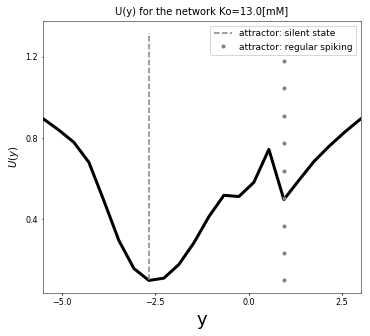

In [88]:
f20, ax= plt.subplots(1,facecolor="1",figsize=(fig_wide,fig_height))

sig_proj_pop=sig_proj




bi=b[1:][::5]
ai=a[::5]
N=1.0/np.trapz(ai, x=bi)
# Uy=(-np.log(ai*N)*2*sig_proj_pop**2)
Uy=-np.log(ai*N)*D
#### This is necessary to avoid numerical errors
bi=bi[np.isfinite(Uy)]
ai=ai[np.isfinite(Uy)]
Uy=Uy[np.isfinite(Uy)]
ax.plot(bi[bi>-5.5],Uy[bi>-5.5], color='black',linewidth=3)


ax.set_title('U(y) for the network '+'Ko='+bifparx[ko][0][bifparx[ko][0].index('(')+1:bifparx[ko][0].index('*')]+'[mM]')
ax.set_xlabel('y',fontsize=size_axis_font)
ax.set_ylabel(r'$U(y)$')

ax.set_xlim([-5.5,3])

att1=bi[bi<0][np.argmin(Uy[bi<0])]
att2=bi[bi>0][np.argmin(Uy[bi>0])]
Pot_i=np.argmax(Uy[(bi>att1)*(bi<att2)])

ax.plot(np.ones(10)*att1,np.linspace(min(Uy[bi>-5.5]),max(Uy[bi>-5.5]),10),'--',color='grey' ,label='attractor: silent state')
ax.plot(np.ones(10)*att2,np.linspace(min(Uy[bi>-5.5]),max(Uy[bi>-5.5]),10),'.',color='grey' ,label='attractor: regular spiking')

ax.legend()
locatory1 = MaxNLocator(nbins=4) # with 3 bins you will have 4 ticks
ax.yaxis.set_major_locator(locatory1)
locatorx1 = MaxNLocator(nbins=4) # with 3 bins you will have 4 ticks
ax.xaxis.set_major_locator(locatorx1)

name_file='Uy_population_'+str(num_neurons)+'_num_runs_'+str(1)+'_lengthSim_'+str(int(time_stim))+'_'
name_i=name_file+stringi

fig_file_title='fig_'+name_i
md_dir={
        'Title':'Potential U of y of population',
        'Author':"Susana Contreras 25/02/2019",
'Subject':'Network simulation '+str(num_neurons)+' neurons snapshot with Ko='+bifparx[ko][0][bifparx[ko][0].index('(')+1:bifparx[ko][0].index('*')]+' '+'I_app'+'='+dir_pars['I_app'][0][0:dir_pars['I_app'][0].index('*')]+' C_E='+str(np.mean(v_in_degree_E))+' C_I='+str(np.mean(v_in_degree_I)),
        'Keywords':"Ko bistability, network synchronization, SNIC, SNL"
        }

# saving_pdf_figure(f20,dir_figs+fig_file_title,md_dir)
# saving_pdf_figure(f20,'./Figs/'+fig_file_title,md_dir)

In [89]:
s_aii=np.zeros(n)
s_aii2=np.zeros(n)
bii=np.linspace(min(bl0_v[0]),max(bl0_v[0]),n)
sum_aai=0
tau_aii=0
for ii,Iapi in enumerate(xxi):
    if Iapi>min(I_app_vv) and Iapi<max(I_app_vv):
        aii=_2gaussian(bii, max(famp1G_iapp(Iapi),0), fcen1G_iapp(Iapi), max(fwid1G_iapp(Iapi),0.1), max(famp2G_iapp(Iapi),0), fcen2G_iapp(Iapi), max(fwid2G_iapp(Iapi),0.1))
#         s_aii2=s_aii2+aw_pos_pop[ii]*aii
        if v_tau_lc[ii]==[]:
            pass
        else:
            tau_aii=tau_aii+v_tau_lc[ii]*aii
            sum_aai=sum_aai+aii
        
tau_eff=tau_aii/sum_aai

In [90]:
### Escape rate..
#5.2.165 Gardiner.. (without simplifications..)
def int1(y,Uy,D,v_yi):
    v_int1=[]
    for yi in v_yi:
        v_int1.append(np.trapz(np.exp(-Uy[:np.argmin(abs(y-yi))]/D),x=y[:np.argmin(abs(y-yi))]))
    return v_int1

def int2(y,Uy,D,at1,barr):
    return np.trapz(np.exp(Uy[np.argmin(abs(y-at1)):np.argmin(abs(y-barr))]/D)*int1(y,Uy,D,y[np.argmin(abs(y-at1)):np.argmin(abs(y-barr))]),x=y[np.argmin(abs(y-at1)):np.argmin(abs(y-barr))])

yyi=bi[1:][np.argmin(np.abs(bi[1:]--3)):np.argmin(np.abs(bi[1:]-1.3))]
Uyyi=Uy[np.argmin(np.abs(bi[1:]--3)):np.argmin(np.abs(bi[1:]-1.3))]

at1=yyi[np.argmin(Uyyi)]
barr=yyi[np.argmax(Uyyi)]
T_at1_barr=(1/D)*int2(yyi,Uyyi,D,at1,barr)
print(T_at1_barr)

####################### Simplification mixing factor
# eq. 9.1.21 gardiner (assuming quadratic potential in the barrier)
def curv_pot(y,Uy,yi):
    iiiavg=10
    xi=y[np.argmin(abs(y-yi))-iiiavg:np.argmin(abs(y-yi))+iiiavg]
    yyi=Uy[np.argmin(abs(y-yi))-iiiavg:np.argmin(abs(y-yi))+iiiavg]
    z = np.polyfit(xi, yyi, 2)
    p = np.poly1d(z)
    return 2*p[0]

from scipy.special import erf
yyi=bi[1:][np.argmin(np.abs(bi[1:]-0.2)):np.argmin(np.abs(bi[1:]-1.3))]
Uyyi=Uy[np.argmin(np.abs(bi[1:]-0.2)):np.argmin(np.abs(bi[1:]-1.3))]

lc_ef=yyi[np.argmin(Uyyi)]
dlc_eff=np.abs(lc_ef-barr)
omega_simpl=(1/2)*(1-erf(dlc_eff*np.sqrt(abs(curv_pot(yyi,Uyyi,barr))/D)))
print(omega_simpl)

179.4845315361495
0.0022041757206143764
